# Tables & plots for paper

In [1]:
import importlib
import os
import pickle
import random
from scipy import stats
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import torch
from sklearn.metrics import average_precision_score, roc_auc_score

from suitability.datasets.wilds import get_wilds_dataset, get_wilds_model
from suitability.filter import suitability_efficient

importlib.reload(suitability_efficient)

from suitability.filter.suitability_efficient import SuitabilityFilter, get_sf_features

# Set seeds for reproducibility
random.seed(32)
np.random.seed(32)

In [90]:
def calculate_metrics(df, significance_level=0.05, col_name='p_value', only_acc=False):
    # Ensure ground_truth and p_value are present
    if "ground_truth" not in df.columns or col_name not in df.columns:
        raise ValueError("DataFrame must contain 'ground_truth' and 'p_value' columns.")

    # Calculate predictions based on significance level
    predictions = (df[col_name] <= significance_level).astype(int)

    # Calculate Accuracy
    accuracy = (predictions == df["ground_truth"]).mean()

    if only_acc:
        return {
            "Accuracy": accuracy
        }

    # Calculate False Positive Rate (FPR)
    false_positives = ((predictions == 1) & (df["ground_truth"] == 0)).sum()
    true_negatives = (df["ground_truth"] == 0).sum()
    fpr = false_positives / true_negatives if true_negatives > 0 else 0.0

    # Calculate ROC AUC and PR AUC
    roc_auc = roc_auc_score(
        df["ground_truth"], -df[col_name]
    )  # Negating p_value as lower is better
    pr_auc = average_precision_score(df["ground_truth"], -df[col_name])

    predictions_2 = (df[col_name] <= 0.01).astype(int)
    accuracy_2 = (predictions_2 == df["ground_truth"]).mean()
    false_positives_2 = ((predictions_2 == 1) & (df["ground_truth"] == 0)).sum()
    true_negatives_2 = (df["ground_truth"] == 0).sum()
    fpr_2 = false_positives_2 / true_negatives_2 if true_negatives_2 > 0 else 0.0

    predictions_3 = (df[col_name] <= 0.001).astype(int)
    accuracy_3 = (predictions_3 == df["ground_truth"]).mean()
    false_positives_3 = ((predictions_3 == 1) & (df["ground_truth"] == 0)).sum()
    true_negatives_3 = (df["ground_truth"] == 0).sum()
    fpr_3 = false_positives_3 / true_negatives_3 if true_negatives_3 > 0 else 0.0

    print(fpr)

    return {
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc,
        "Accuracy": accuracy,
        "FPR": fpr,
        "Accuracy@0.01": accuracy_2,
        "FPR@0.01": fpr_2,
        "Accuracy@0.001": accuracy_3,
        "FPR@0.001": fpr_3
    }

## Table 1

In [3]:
def calculate_ci(values, confidence_level=0.95):
    """
    Calculate the mean and the confidence interval for a given set of values.
    """
    mean_val = np.mean(values)
    sem = stats.sem(values)  # Standard error of the mean
    margin_of_error = sem * stats.t.ppf((1 + confidence_level) / 2., len(values)-1)
    return mean_val, margin_of_error

In [91]:
def get_agg_results_df(dataset="fmow", user_data="id"):
    if dataset == "fmow":
        results_df_0 = pd.read_csv(f"suitability/results/sf_evals/erm/{dataset}_sf_results_{user_data}_subsets_ERM_last_0_NEW.csv")
        results_df_1 = pd.read_csv(f"suitability/results/sf_evals/erm/{dataset}_sf_results_{user_data}_subsets_ERM_last_1_NEW.csv")
        results_df_2 = pd.read_csv(f"suitability/results/sf_evals/erm/{dataset}_sf_results_{user_data}_subsets_ERM_last_2_NEW.csv")

    else:
    # Read CSV files
        results_df_0 = pd.read_csv(f"suitability/results/sf_evals/erm/{dataset}_sf_results_{user_data}_subsets_ERM_last_0.csv")
        results_df_1 = pd.read_csv(f"suitability/results/sf_evals/erm/{dataset}_sf_results_{user_data}_subsets_ERM_last_1.csv")
        results_df_2 = pd.read_csv(f"suitability/results/sf_evals/erm/{dataset}_sf_results_{user_data}_subsets_ERM_last_2.csv")

    margin = 0

    # Include only margin = 0
    results_df_0 = results_df_0[results_df_0["margin"] == margin]
    results_df_1 = results_df_1[results_df_1["margin"] == margin]
    results_df_2 = results_df_2[results_df_2["margin"] == margin]

    # Collecting all results DataFrames
    results_dfs = [results_df_0, results_df_1, results_df_2]

    agg_results = []

    # Iterate over unique margins and feature subsets
    for feature_subset in results_df_0["feature_subset"].unique():  # Assuming all result DFs have same feature subsets
        if  len(feature_subset) < 38:
            continue
        elif dataset == "civilcomments" and feature_subset == "[10]":
            continue
        subset_dfs = [df[df["feature_subset"] == feature_subset] for df in results_dfs]
        
        # Calculate metrics for each DataFrame
        metrics_list = [calculate_metrics(subset_df) for subset_df in subset_dfs]
        
        # Calculate mean and 95% CI for each metric
        aggregated_metrics = {}
        for metric in metrics_list[0].keys():  # Assuming all metrics are the same across DataFrames
            metric_values = [metrics[metric] for metrics in metrics_list]
            mean_val, margin_of_error = calculate_ci(metric_values)
            aggregated_metrics[metric] = mean_val
            aggregated_metrics[f"{metric} MoE"] = margin_of_error
        
        # Append to the results
        agg_results.append({
            "feature_subset": feature_subset,
            **aggregated_metrics
        })

    # Convert to DataFrame
    agg_results_df = pd.DataFrame(agg_results)
    agg_results_df = agg_results_df.sort_values(by="Accuracy", ascending=False)
    return agg_results_df.sort_values(by='Accuracy', ascending=False)

In [45]:
agg_results_df = get_agg_results_df()

def format_latex_row(row):
    feature_name_dict = {
        "[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]": "Suitability Filter",
        "[0]": r"\texttt{conf\_max}",
        "[1]": r"\texttt{conf\_std}",
        "[2]": r"\texttt{conf\_entropy}",
        "[3]": r"\texttt{logit\_mean}",
        "[4]": r"\texttt{logit\_max}",
        "[5]": r"\texttt{logit\_std}",
        "[6]": r"\texttt{logit\_diff\_top2}",
        "[7]": r"\texttt{loss}",
        "[8]": r"\texttt{margin\_loss}",
        "[9]": r"\texttt{conf\_ratio}",
        "[10]": r"\texttt{top\_k\_conf\_sum}",
        "[11]": r"\texttt{energy}"
    }

    # Format each metric value as LaTeX expression
    roc_auc = f"${row['ROC AUC']:.3f}$"
    pr_auc = f"${row['PR AUC']:.3f}$"
    accuracy = f"${row['Accuracy'] * 100:.1f}\\%$"
    fpr = f"${row['FPR']:.3f}$"

    # Combine into a single row for LaTeX table
    return f"{feature_name_dict[str(row['feature_subset'])]} & {accuracy} & {fpr} & {roc_auc} & {pr_auc} \\\\"

latex_table = "\\begin{tabular}{lcccc}\n"
latex_table += "\\toprule\n"
latex_table += "Method & Acc & FPR & ROC & PR \\\\ \n"
latex_table += "\\toprule\n"

for index, row in agg_results_df.iterrows():
    latex_table += format_latex_row(row) + "\n"

latex_table += "\\bottomrule\n"
latex_table += "\\end{tabular}"

# Print the LaTeX code for the table
print(latex_table)

\begin{tabular}{lcccc}
\toprule
Method & Acc & FPR & ROC & PR \\ 
\toprule
Suitability Filter & $81.8\%$ & $0.027$ & $0.969$ & $0.967$ \\
\texttt{energy} & $80.6\%$ & $0.024$ & $0.965$ & $0.962$ \\
\texttt{logit\_max} & $80.2\%$ & $0.025$ & $0.965$ & $0.963$ \\
\texttt{logit\_mean} & $80.1\%$ & $0.112$ & $0.918$ & $0.896$ \\
\texttt{logit\_diff\_top2} & $73.5\%$ & $0.008$ & $0.963$ & $0.963$ \\
\texttt{margin\_loss} & $73.5\%$ & $0.008$ & $0.963$ & $0.963$ \\
\texttt{logit\_std} & $72.3\%$ & $0.170$ & $0.855$ & $0.779$ \\
\texttt{conf\_entropy} & $71.1\%$ & $0.003$ & $0.969$ & $0.967$ \\
\texttt{conf\_std} & $68.8\%$ & $0.008$ & $0.963$ & $0.960$ \\
\texttt{top\_k\_conf\_sum} & $68.2\%$ & $0.005$ & $0.947$ & $0.944$ \\
\texttt{conf\_max} & $67.9\%$ & $0.008$ & $0.957$ & $0.954$ \\
\texttt{loss} & $67.0\%$ & $0.008$ & $0.952$ & $0.948$ \\
\texttt{conf\_ratio} & $62.3\%$ & $0.046$ & $0.846$ & $0.826$ \\
\bottomrule
\end{tabular}


## Table 1 (extended for Appendix)

In [46]:
agg_results_df_id = get_agg_results_df("fmow", "id")
agg_results_df_ood = get_agg_results_df("fmow", "ood")

def format_latex_row(row):
    feature_name_dict = {
        "[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]": "Suitability Filter",
        "[0]": r"\texttt{conf\_max}",
        "[1]": r"\texttt{conf\_std}",
        "[2]": r"\texttt{conf\_entropy}",
        "[3]": r"\texttt{logit\_mean}",
        "[4]": r"\texttt{logit\_max}",
        "[5]": r"\texttt{logit\_std}",
        "[6]": r"\texttt{logit\_diff\_top2}",
        "[7]": r"\texttt{loss}",
        "[8]": r"\texttt{margin\_loss}",
        "[9]": r"\texttt{conf\_ratio}",
        "[10]": r"\texttt{top\_k\_conf\_sum}",
        "[11]": r"\texttt{energy}"
    }

    # Format each metric value as LaTeX expression
    roc_auc = f"${row['ROC AUC']:.3f} \pm {row['ROC AUC MoE']:.3f}$"
    pr_auc = f"${row['PR AUC']:.3f} \pm {row['PR AUC MoE']:.3f}$"
    accuracy = f"${row['Accuracy'] * 100:.1f} \pm {row['Accuracy MoE'] * 100:.1f} \\%$"
    fpr = f"${row['FPR']:.3f} \pm {row['FPR MoE']:.3f}$"
    

    # Combine into a single row for LaTeX table
    return f"{feature_name_dict[str(row['feature_subset'])]} & {accuracy} & {fpr} & {roc_auc} & {pr_auc} \\\\ \n"

latex_table = "\\begin{tabular}{lcccc}\n"
latex_table += "\\toprule\n"
latex_table += "Method & Acc & FPR & ROC & PR  \\\\ \n"
latex_table += "\\midrule\n"
latex_table += "\\multicolumn{5}{c}{ID User Data} \\\\ \n"
latex_table += "\\midrule\n"

# Iterate over the merged DataFrame to generate rows
for index, row in agg_results_df_id.iterrows():
    latex_table += format_latex_row(row)

latex_table += "\\midrule\n"
latex_table += "\\multicolumn{5}{c}{OOD User Data} \\\\ \n"
latex_table += "\\midrule\n"

# Iterate over the merged DataFrame to generate rows
for index, row in agg_results_df_ood.iterrows():
    latex_table += format_latex_row(row)

latex_table += "\\bottomrule\n"
latex_table += "\\end{tabular}"

# Print the LaTeX code for the table
print(latex_table)


\begin{tabular}{lcccc}
\toprule
Method & Acc & FPR & ROC & PR  \\ 
\midrule
\multicolumn{5}{c}{ID User Data} \\ 
\midrule
Suitability Filter & $81.8 \pm 3.1 \%$ & $0.027 \pm 0.033$ & $0.969 \pm 0.023$ & $0.967 \pm 0.029$ \\ 
\texttt{energy} & $80.6 \pm 4.3 \%$ & $0.024 \pm 0.040$ & $0.965 \pm 0.020$ & $0.962 \pm 0.033$ \\ 
\texttt{logit\_max} & $80.2 \pm 4.8 \%$ & $0.025 \pm 0.041$ & $0.965 \pm 0.018$ & $0.963 \pm 0.030$ \\ 
\texttt{logit\_mean} & $80.1 \pm 10.4 \%$ & $0.112 \pm 0.194$ & $0.918 \pm 0.113$ & $0.896 \pm 0.196$ \\ 
\texttt{logit\_diff\_top2} & $73.5 \pm 4.5 \%$ & $0.008 \pm 0.001$ & $0.963 \pm 0.017$ & $0.963 \pm 0.017$ \\ 
\texttt{margin\_loss} & $73.5 \pm 4.5 \%$ & $0.008 \pm 0.001$ & $0.963 \pm 0.017$ & $0.963 \pm 0.017$ \\ 
\texttt{logit\_std} & $72.3 \pm 13.3 \%$ & $0.170 \pm 0.134$ & $0.855 \pm 0.144$ & $0.779 \pm 0.300$ \\ 
\texttt{conf\_entropy} & $71.1 \pm 2.4 \%$ & $0.003 \pm 0.012$ & $0.969 \pm 0.014$ & $0.967 \pm 0.012$ \\ 
\texttt{conf\_std} & $68.8 \pm 3.1 \

### Significance Level Table for Appendix

In [38]:
agg_results_df_id = get_agg_results_df()
agg_results_df_ood = get_agg_results_df("ood")

def format_latex_row(row):
    feature_name_dict = {
        "[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]": "Suitability Filter",
        "[0]": r"\texttt{conf\_max}",
        "[1]": r"\texttt{conf\_std}",
        "[2]": r"\texttt{conf\_entropy}",
        "[3]": r"\texttt{logit\_mean}",
        "[4]": r"\texttt{logit\_max}",
        "[5]": r"\texttt{logit\_std}",
        "[6]": r"\texttt{logit\_diff\_top2}",
        "[7]": r"\texttt{loss}",
        "[8]": r"\texttt{margin\_loss}",
        "[9]": r"\texttt{conf\_ratio}",
        "[10]": r"\texttt{top\_k\_conf\_sum}",
        "[11]": r"\texttt{energy}"
    }

    # Format each metric value as LaTeX expression
    accuracy = f"${row['Accuracy'] * 100:.1f} \pm {row['Accuracy MoE'] * 100:.1f} \\%$"
    fpr = f"${row['FPR']:.3f} \pm {row['FPR MoE']:.3f}$"
    accuracy_2 = f"${row['Accuracy@0.01'] * 100:.1f} \pm {row['Accuracy@0.01 MoE'] * 100:.1f} \\%$"
    fpr_2 = f"${row['FPR@0.01']:.3f} \pm {row['FPR@0.01 MoE']:.3f}$"
    accuracy_3 = f"${row['Accuracy@0.001'] * 100:.1f} \pm {row['Accuracy@0.001 MoE'] * 100:.1f} \\%$"
    fpr_3 = f"${row['FPR@0.001']:.3f} \pm {row['FPR@0.001 MoE']:.3f}$"

    # Combine into a single row for LaTeX table
    return f"{feature_name_dict[str(row['feature_subset'])]} & {accuracy} & {fpr} & {accuracy_2} & {fpr_2} & {accuracy_3} & {fpr_3} \\\\ \n"

latex_table = "\\begin{tabular}{lcccccc}\n"
latex_table += "\\toprule\n"
latex_table += "Method & Acc @ 0.05 & FPR @ 0.05 & Acc @ 0.01 & FPR @ 0.01 & Acc @ 0.001 & FPR @ 0.001  \\\\ \n"
latex_table += "\\midrule\n"
latex_table += "\\multicolumn{7}{c}{ID User Data} \\\\ \n"
latex_table += "\\midrule\n"

# Iterate over the merged DataFrame to generate rows
for index, row in agg_results_df_id.iterrows():
    latex_table += format_latex_row(row)

latex_table += "\\midrule\n"
latex_table += "\\multicolumn{7}{c}{OOD User Data} \\\\ \n"
latex_table += "\\midrule\n"

# Iterate over the merged DataFrame to generate rows
for index, row in agg_results_df_ood.iterrows():
    latex_table += format_latex_row(row)

latex_table += "\\bottomrule\n"
latex_table += "\\end{tabular}"

# Print the LaTeX code for the table
print(latex_table)


\begin{tabular}{lcccccc}
\toprule
Method & Acc @ 0.05 & FPR @ 0.05 & Acc @ 0.01 & FPR @ 0.01 & Acc @ 0.001 & FPR @ 0.001  \\ 
\midrule
\multicolumn{7}{c}{ID User Data} \\ 
\midrule
Suitability Filter & $81.5 \pm 5.0 \%$ & $0.027 \pm 0.041$ & $75.4 \pm 4.2 \%$ & $0.007 \pm 0.019$ & $65.9 \pm 3.1 \%$ & $0.000 \pm 0.002$ \\ 
\texttt{energy} & $80.8 \pm 3.0 \%$ & $0.029 \pm 0.038$ & $74.0 \pm 0.4 \%$ & $0.009 \pm 0.032$ & $63.6 \pm 4.1 \%$ & $0.001 \pm 0.005$ \\ 
\texttt{logit\_max} & $80.6 \pm 3.2 \%$ & $0.026 \pm 0.033$ & $73.9 \pm 0.1 \%$ & $0.007 \pm 0.022$ & $63.4 \pm 3.6 \%$ & $0.000 \pm 0.000$ \\ 
\texttt{logit\_mean} & $80.0 \pm 9.1 \%$ & $0.122 \pm 0.203$ & $74.9 \pm 16.2 \%$ & $0.089 \pm 0.181$ & $69.3 \pm 19.6 \%$ & $0.043 \pm 0.099$ \\ 
\texttt{logit\_diff\_top2} & $75.8 \pm 5.1 \%$ & $0.007 \pm 0.019$ & $67.0 \pm 3.4 \%$ & $0.000 \pm 0.000$ & $58.7 \pm 2.9 \%$ & $0.000 \pm 0.000$ \\ 
\texttt{margin\_loss} & $75.8 \pm 5.1 \%$ & $0.007 \pm 0.019$ & $67.0 \pm 3.4 \%$ & $0.000 \pm

## Figure 2

(28980, 24)
bin
-5% to -4%    2436
-3% to -2%    2324
-6% to -5%    2198
-2% to -1%    2170
0% to 1%      2100
-4% to -3%    2072
-1% to 0%     1960
1% to 2%      1862
-7% to -6%    1694
2% to 3%      1260
3% to 4%      1064
4% to 5%       882
5% to 6%       686
6% to 7%       546
Name: count, dtype: int64
           bin  percentage_p_value_less_0.05
0   -7% to -6%                      0.000000
1   -6% to -5%                      0.000000
2   -5% to -4%                      0.000000
3   -4% to -3%                      0.000000
4   -3% to -2%                      0.645439
5   -2% to -1%                      2.626728
6    -1% to 0%                     16.938776
7     0% to 1%                     30.380952
8     1% to 2%                     55.585392
9     2% to 3%                     63.809524
10    3% to 4%                     86.654135
11    4% to 5%                     93.310658
12    5% to 6%                     99.125364
13    6% to 7%                    100.000000


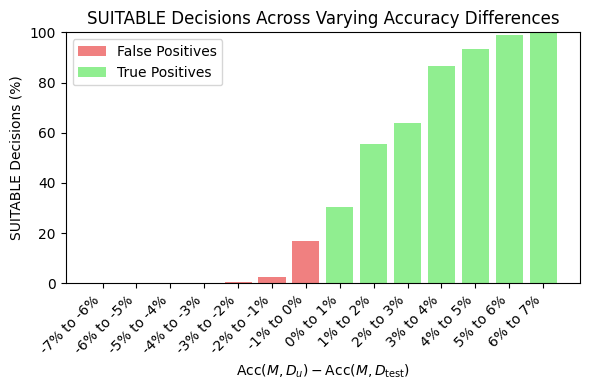

In [79]:
results_df_0 = pd.read_csv(f"suitability/results/sf_evals/erm/fmow_sf_results_id_subsets_ERM_last_0_NEW.csv")
results_df_1 = pd.read_csv(f"suitability/results/sf_evals/erm/fmow_sf_results_id_subsets_ERM_last_1_NEW.csv")
results_df_2 = pd.read_csv(f"suitability/results/sf_evals/erm/fmow_sf_results_id_subsets_ERM_last_2_NEW.csv")
results_df_3 = pd.read_csv(f"suitability/results/sf_evals/erm/fmow_sf_results_ood_subsets_ERM_last_0_NEW.csv")
results_df_4 = pd.read_csv(f"suitability/results/sf_evals/erm/fmow_sf_results_ood_subsets_ERM_last_1_NEW.csv")
results_df_5 = pd.read_csv(f"suitability/results/sf_evals/erm/fmow_sf_results_ood_subsets_ERM_last_2_NEW.csv")

margin = 0

# Include only margin = 0
results_df_0 = results_df_0[results_df_0["margin"] == margin]
results_df_1 = results_df_1[results_df_1["margin"] == margin]
results_df_2 = results_df_2[results_df_2["margin"] == margin]
results_df_3 = results_df_3[results_df_3["margin"] == margin]
results_df_4 = results_df_4[results_df_4["margin"] == margin]
results_df_5 = results_df_5[results_df_5["margin"] == margin]

for feature_subset in results_df_0["feature_subset"].unique():  # Assuming all result DFs have same feature subsets
        if len(feature_subset) < 38:
            continue
        results_df_0 = results_df_0[results_df_0["feature_subset"] == feature_subset]
        results_df_1 = results_df_1[results_df_1["feature_subset"] == feature_subset]
        results_df_2 = results_df_2[results_df_2["feature_subset"] == feature_subset]
        results_df_3 = results_df_3[results_df_3["feature_subset"] == feature_subset]
        results_df_4 = results_df_4[results_df_4["feature_subset"] == feature_subset]
        results_df_5 = results_df_5[results_df_5["feature_subset"] == feature_subset]

        # Define bins for 'acc_diff'
        bins = np.linspace(-0.07, 0.07, 15)
        bin_labels = [f"{100*bins[i]:.0f}% to {100*bins[i+1]:.0f}%" for i in range(len(bins) - 1)]

        # Assign 'acc_diff' values to bins for all dataframes
        for df in [results_df_0, results_df_1, results_df_2, results_df_3, results_df_4, results_df_5]:
            df['bin'] = pd.cut(df['acc_diff'], bins=bins, labels=bin_labels, include_lowest=True)

        # Concatenate all dataframes into one
        combined_df = pd.concat([results_df_0, results_df_1, results_df_2, results_df_3, results_df_4, results_df_5])

        # Print number of rows of combined_df
        print(combined_df.shape)
        print(combined_df['bin'].value_counts())

        # Calculate the percentage of p-values < 0.05 for each bin
        bin_p_value_percentages = (
            combined_df.groupby('bin', observed=False)['p_value']
            .apply(lambda x: (x < 0.05).mean() * 100)
            .reset_index(name='percentage_p_value_less_0.05')
        )

        print(bin_p_value_percentages)

        # Plot the results
        plt.figure(figsize=(6, 4))
        plt.bar(bin_p_value_percentages['bin'][:7], bin_p_value_percentages['percentage_p_value_less_0.05'][:7], color='lightcoral', label='False Positives')
        plt.bar(bin_p_value_percentages['bin'][7:], bin_p_value_percentages['percentage_p_value_less_0.05'][7:], color='lightgreen', label='True Positives')
plt.xticks(rotation=45, ha='right')
plt.xlabel(r'$\text{Acc}(M,D_u)-\text{Acc}(M,D_{\text{test}})$')
plt.ylabel('SUITABLE Decisions (%)')
plt.title(r'SUITABLE Decisions Across Varying Accuracy Differences')
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()

## Regressor plots & tables (ANOVA, SHAP, comparing classifiers, calibration)

In [6]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.calibration import calibration_curve
from sklearn.feature_selection import f_classif
import shap
from tqdm import tqdm

cache_file = "suitability/results/features/fmow_ERM_last_0.pkl"

if os.path.exists(cache_file):
    with open(cache_file, "rb") as f:
        full_feature_dict = pickle.load(f)

id_features_val, id_corr_val = full_feature_dict["id_val"]
id_features_test, id_corr_test = full_feature_dict["id_test"]
features = np.concatenate([id_features_val, id_features_test], axis=0)
corr = np.concatenate([id_corr_val, id_corr_test], axis=0)

permutation = np.random.permutation(len(features))

features_shuffled = features[permutation]
corr_shuffled = corr[permutation]

### Table 4

In [ ]:
def compute_calibration_metrics(y_true, y_prob):
    # Get calibration curve for the model's predicted probabilities
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_prob, n_bins=10)
    ece = np.mean(np.abs(fraction_of_positives - mean_predicted_value))
    mce = np.max(np.abs(fraction_of_positives - mean_predicted_value))
    rmsce = np.sqrt(np.mean((fraction_of_positives - mean_predicted_value) ** 2))
    
    return ece, mce, rmsce

# Number of random splits
num_splits = 3
train_size = 0.8

# Store accuracies for each model and split
results = {classifier: {'accuracies': [], 'eces': [], 'mces': [], 'rmsces': [], 'max_diffs': []} for classifier in ["logistic_regression", "svm", "random_forest", "gradient_boosting", "mlp", "mlp_2", "decision_tree"]}

# Perform 10 random splits
for _ in tqdm(range(num_splits)):
    # Split the data
    train_features, test_features, train_corr, test_corr = train_test_split(features_shuffled, corr_shuffled, train_size=train_size)
    
    # Standardize features
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)
    test_features = scaler.transform(test_features)

    for classifier in results:
        # Select the model
        if classifier == "logistic_regression":
            model = LogisticRegression(max_iter=1000)
        elif classifier == "svm":
            model = SVC(probability=True)
        elif classifier == "random_forest":
            model = RandomForestClassifier()
        elif classifier == "gradient_boosting":
            model = GradientBoostingClassifier()
        elif classifier == "mlp":
            model = MLPClassifier(max_iter=1000)
        elif classifier == "mlp_2":
            model = MLPClassifier(max_iter=1000, hidden_layer_sizes=(100, 100))
        elif classifier == "decision_tree":
            model = DecisionTreeClassifier()

        # Train the model
        calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv=5)

        # Calibrate the model's probabilities
        calibrated_model.fit(train_features, train_corr)

        # Predict on the test set
        test_corr_pred = calibrated_model.predict(test_features)
        test_prob = calibrated_model.predict_proba(test_features)[:, 1]

        # Compute accuracy
        accuracy = accuracy_score(test_corr, test_corr_pred)
        ece, mce, rmsce = compute_calibration_metrics(test_corr, test_prob)

        results[classifier]['accuracies'].append(accuracy)
        results[classifier]['eces'].append(ece)
        results[classifier]['mces'].append(mce)
        results[classifier]['rmsces'].append(rmsce)


# Now compute the 95% confidence intervals for each model's accuracy
for classifier, metrics in results.items():
    mean_accuracy = np.mean(metrics['accuracies'])
    accuracy_conf_interval = stats.t.interval(0.95, len(metrics['accuracies'])-1, loc=mean_accuracy, scale=stats.sem(metrics['accuracies']))
    
    mean_ece = np.mean(metrics['eces'])
    ece_conf_interval = stats.t.interval(0.95, len(metrics['eces'])-1, loc=mean_ece, scale=stats.sem(metrics['eces']))
    
    mean_mce = np.mean(metrics['mces'])
    mce_conf_interval = stats.t.interval(0.95, len(metrics['mces'])-1, loc=mean_mce, scale=stats.sem(metrics['mces']))
    
    mean_rmsce = np.mean(metrics['rmsces'])
    rmsce_conf_interval = stats.t.interval(0.95, len(metrics['rmsces'])-1, loc=mean_rmsce, scale=stats.sem(metrics['rmsces']))

In [15]:
# Map internal classifier keys to display names
classifier_display_names = {
    "mlp": "Single-Layer Neural Network",
    "logistic_regression": "Logistic Regression",
    "svm": "Support Vector Machine",
    "gradient_boosting": "Gradient Boosting Classifier",
    "random_forest": "Random Forest",
    "mlp_2": "Two-Layer Neural Network",
    "decision_tree": "Decision Tree"
}

# Initialize LaTeX table
latex_table = r"""
\begin{tabular}{lcccc}
\toprule
Classifier & Accuracy (\%) & ECE & MCE & RMSCE \\
\midrule
"""

# Generate table rows
for classifier, metrics in results.items():
    # Compute mean and margin of error for each metric
    mean_accuracy, accuracy_moe = calculate_ci(metrics['accuracies'])
    mean_ece, ece_moe = calculate_ci(metrics['eces'])
    mean_mce, mce_moe = calculate_ci(metrics['mces'])
    mean_rmsce, rmsce_moe = calculate_ci(metrics['rmsces'])
    
    # Use display names for classifiers
    display_name = classifier_display_names[classifier]
    
    # Add row to the table
    latex_table += (
        f"{display_name} & "
        f"${mean_accuracy*100:.1f} \pm {accuracy_moe*100:.1f}$ & "
        f"${mean_ece:.3f} \pm {ece_moe:.3f}$ & "
        f"${mean_mce:.3f} \pm {mce_moe:.3f}$ & "
        f"${mean_rmsce:.3f} \pm {rmsce_moe:.3f}$ \\\\\n"
    )

# Close LaTeX table
latex_table += r"""
\bottomrule
\end{tabular}
"""

# Print LaTeX table
print(latex_table)



\begin{tabular}{lcccc}
\toprule
Classifier & Accuracy (\%) & ECE & MCE & RMSCE \\
\midrule
Logistic Regression & $77.2 \pm 1.4$ & $0.022 \pm 0.004$ & $0.055 \pm 0.040$ & $0.027 \pm 0.007$ \\
Support Vector Machine & $77.1 \pm 0.9$ & $0.077 \pm 0.034$ & $0.232 \pm 0.147$ & $0.107 \pm 0.050$ \\
Random Forest & $76.5 \pm 0.9$ & $0.031 \pm 0.007$ & $0.067 \pm 0.068$ & $0.037 \pm 0.016$ \\
Gradient Boosting Classifier & $77.1 \pm 1.3$ & $0.020 \pm 0.018$ & $0.062 \pm 0.102$ & $0.027 \pm 0.030$ \\
Single-Layer Neural Network & $77.1 \pm 1.2$ & $0.037 \pm 0.006$ & $0.086 \pm 0.017$ & $0.046 \pm 0.006$ \\
Two-Layer Neural Network & $75.7 \pm 2.3$ & $0.040 \pm 0.006$ & $0.087 \pm 0.012$ & $0.048 \pm 0.002$ \\
Decision Tree & $70.7 \pm 0.9$ & $0.111 \pm 0.021$ & $0.161 \pm 0.050$ & $0.123 \pm 0.029$ \\

\bottomrule
\end{tabular}



In [ ]:
# Number of random splits
num_splits = 3
train_size = 0.8

feature_subsets = [
    [0],
    [1],
    [2],
    [3],
    [4],
    [5],
    [6],
    [7],
    [8],
    [9],
    [10],
    [11],
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
]

# Store accuracies for each model and split
results = {str(feature_sub): {'accuracies': [], 'eces': [], 'mces': [], 'rmsces': [], 'max_diffs': []} for feature_sub in feature_subsets}

# Perform 10 random splits
for _ in tqdm(range(num_splits)):
    # Split the data
    train_features, test_features, train_corr, test_corr = train_test_split(features_shuffled, corr_shuffled, train_size=train_size)
    
    # Standardize features
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)
    test_features = scaler.transform(test_features)

    for feature_sub in feature_subsets:
        # Select the model
        model = LogisticRegression(max_iter=1000)

        # Get the subset of features
        train_features_sub = train_features[:, feature_sub]
        test_features_sub = test_features[:, feature_sub]

        # Train the model
        calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv=5)

        # Calibrate the model's probabilities
        calibrated_model.fit(train_features_sub, train_corr)

        # Predict on the test set
        test_corr_pred = calibrated_model.predict(test_features_sub)
        test_prob = calibrated_model.predict_proba(test_features_sub)[:, 1]

        # Compute accuracy
        accuracy = accuracy_score(test_corr, test_corr_pred)
        ece, mce, rmsce = compute_calibration_metrics(test_corr, test_prob)

        results[str(feature_sub)]['accuracies'].append(accuracy)
        results[str(feature_sub)]['eces'].append(ece)
        results[str(feature_sub)]['mces'].append(mce)
        results[str(feature_sub)]['rmsces'].append(rmsce)


# Now compute the 95% confidence intervals for each model's accuracy
for subset, metrics in results.items():
    mean_accuracy = np.mean(metrics['accuracies'])
    accuracy_conf_interval = stats.t.interval(0.95, len(metrics['accuracies'])-1, loc=mean_accuracy, scale=stats.sem(metrics['accuracies']))
    
    mean_ece = np.mean(metrics['eces'])
    ece_conf_interval = stats.t.interval(0.95, len(metrics['eces'])-1, loc=mean_ece, scale=stats.sem(metrics['eces']))
    
    mean_mce = np.mean(metrics['mces'])
    mce_conf_interval = stats.t.interval(0.95, len(metrics['mces'])-1, loc=mean_mce, scale=stats.sem(metrics['mces']))
    
    mean_rmsce = np.mean(metrics['rmsces'])
    rmsce_conf_interval = stats.t.interval(0.95, len(metrics['rmsces'])-1, loc=mean_rmsce, scale=stats.sem(metrics['rmsces']))

In [39]:
feature_name_dict = {
        "[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]": "Suitability Filter",
        "[0]": r"\texttt{conf\_max}",
        "[1]": r"\texttt{conf\_std}",
        "[2]": r"\texttt{conf\_entropy}",
        "[3]": r"\texttt{logit\_mean}",
        "[4]": r"\texttt{logit\_max}",
        "[5]": r"\texttt{logit\_std}",
        "[6]": r"\texttt{logit\_diff\_top2}",
        "[7]": r"\texttt{loss}",
        "[8]": r"\texttt{margin\_loss}",
        "[9]": r"\texttt{conf\_ratio}",
        "[10]": r"\texttt{top\_k\_conf\_sum}",
        "[11]": r"\texttt{energy}"
    }

latex_table = "\\begin{tabular}{lcccc}\n"
latex_table += "\\toprule\n"
latex_table += "Feature Subset & Accuracy & ECE & MCE  \\\\\n"
latex_table += "\\midrule\n"

for feature_subset, metrics in results.items():
    feature_name = feature_name_dict.get(feature_subset, feature_subset)
    
    # Compute means and confidence intervals
    mean_accuracy = np.mean(metrics['accuracies'])
    ci_accuracy = stats.t.interval(0.95, len(metrics['accuracies']) - 1, loc=mean_accuracy, scale=stats.sem(metrics['accuracies']))
    accuracy_str = f"${mean_accuracy * 100:.1f} \% $"
    
    mean_ece = np.mean(metrics['eces'])
    ci_ece = stats.t.interval(0.95, len(metrics['eces']) - 1, loc=mean_ece, scale=stats.sem(metrics['eces']))
    ece_str = f"${mean_ece:.3f} $"
    
    mean_mce = np.mean(metrics['mces'])
    ci_mce = stats.t.interval(0.95, len(metrics['mces']) - 1, loc=mean_mce, scale=stats.sem(metrics['mces']))
    mce_str = f"${mean_mce:.3f} $"
    
    mean_rmsce = np.mean(metrics['rmsces'])
    ci_rmsce = stats.t.interval(0.95, len(metrics['rmsces']) - 1, loc=mean_rmsce, scale=stats.sem(metrics['rmsces']))
    rmsce_str = f"${mean_rmsce:.3f} $"
    
    # Add row to table
    latex_table += f"{feature_name} & {accuracy_str} & {ece_str} & {mce_str}  \\\\\n"

latex_table += "\\bottomrule\n\\end{tabular}\n"

print(latex_table)

\begin{tabular}{lcccc}
\toprule
Feature Subset & Accuracy & ECE & MCE  \\
\midrule
\texttt{conf\_max} & $72.7 \% $ & $0.116 $ & $0.260 $  \\
\texttt{conf\_std} & $73.2 \% $ & $0.104 $ & $0.263 $  \\
\texttt{conf\_entropy} & $74.4 \% $ & $0.089 $ & $0.208 $  \\
\texttt{logit\_mean} & $67.1 \% $ & $0.081 $ & $0.268 $  \\
\texttt{logit\_max} & $76.6 \% $ & $0.027 $ & $0.068 $  \\
\texttt{logit\_std} & $59.8 \% $ & $0.132 $ & $0.294 $  \\
\texttt{logit\_diff\_top2} & $75.5 \% $ & $0.021 $ & $0.060 $  \\
\texttt{loss} & $72.0 \% $ & $0.121 $ & $0.265 $  \\
\texttt{margin\_loss} & $75.5 \% $ & $0.021 $ & $0.060 $  \\
\texttt{conf\_ratio} & $61.1 \% $ & $0.144 $ & $0.320 $  \\
\texttt{top\_k\_conf\_sum} & $67.7 \% $ & $0.146 $ & $0.301 $  \\
\texttt{energy} & $76.3 \% $ & $0.029 $ & $0.075 $  \\
Suitability Filter & $77.5 \% $ & $0.021 $ & $0.055 $  \\
\bottomrule
\end{tabular}



In [ ]:
feature_name_dict = {
        "[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]": "Suitability Filter",
        "[0]": r"\texttt{conf\_max}",
        "[1]": r"\texttt{conf\_std}",
        "[2]": r"\texttt{conf\_entropy}",
        "[3]": r"\texttt{logit\_mean}",
        "[4]": r"\texttt{logit\_max}",
        "[5]": r"\texttt{logit\_std}",
        "[6]": r"\texttt{logit\_diff\_top2}",
        "[7]": r"\texttt{loss}",
        "[8]": r"\texttt{margin\_loss}",
        "[9]": r"\texttt{conf\_ratio}",
        "[10]": r"\texttt{top\_k\_conf\_sum}",
        "[11]": r"\texttt{energy}"
    }

latex_table = "\\begin{tabular}{lcccc}\n"
latex_table += "\\toprule\n"
latex_table += "Feature Subset & Accuracy & ECE & MCE & RMSCE \\\\\n"
latex_table += "\\midrule\n"

for feature_subset, metrics in results.items():
    feature_name = feature_name_dict.get(feature_subset, feature_subset)
    
    # Compute means and confidence intervals
    mean_accuracy = np.mean(metrics['accuracies'])
    ci_accuracy = stats.t.interval(0.95, len(metrics['accuracies']) - 1, loc=mean_accuracy, scale=stats.sem(metrics['accuracies']))
    accuracy_str = f"${mean_accuracy * 100:.1f} \\pm {(ci_accuracy[1] - mean_accuracy) * 100:.1f} \% $"
    
    mean_ece = np.mean(metrics['eces'])
    ci_ece = stats.t.interval(0.95, len(metrics['eces']) - 1, loc=mean_ece, scale=stats.sem(metrics['eces']))
    ece_str = f"${mean_ece:.3f} \\pm {(ci_ece[1] - mean_ece):.3f}$"
    
    mean_mce = np.mean(metrics['mces'])
    ci_mce = stats.t.interval(0.95, len(metrics['mces']) - 1, loc=mean_mce, scale=stats.sem(metrics['mces']))
    mce_str = f"${mean_mce:.3f} \\pm {(ci_mce[1] - mean_mce):.3f}$"
    
    mean_rmsce = np.mean(metrics['rmsces'])
    ci_rmsce = stats.t.interval(0.95, len(metrics['rmsces']) - 1, loc=mean_rmsce, scale=stats.sem(metrics['rmsces']))
    rmsce_str = f"${mean_rmsce:.3f} \\pm {(ci_rmsce[1] - mean_rmsce):.3f}$"
    
    # Add row to table
    latex_table += f"{feature_name} & {accuracy_str} & {ece_str} & {mce_str} & {rmsce_str} \\\\\n"

latex_table += "\\bottomrule\n\\end{tabular}\n"

print(latex_table)

\begin{tabular}{lcccc}
\toprule
Feature Subset & Accuracy (\%) & ECE & MCE & RMSCE \\
\midrule
\texttt{conf\_max} & $72.7 \pm 0.5 \% $ & $0.116 \pm 0.014$ & $0.260 \pm 0.056$ & $0.143 \pm 0.015$ \\
\texttt{conf\_std} & $73.2 \pm 0.6 \% $ & $0.104 \pm 0.020$ & $0.263 \pm 0.068$ & $0.134 \pm 0.013$ \\
\texttt{conf\_entropy} & $74.4 \pm 0.9 \% $ & $0.089 \pm 0.007$ & $0.208 \pm 0.055$ & $0.113 \pm 0.009$ \\
\texttt{logit\_mean} & $67.1 \pm 2.3 \% $ & $0.081 \pm 0.033$ & $0.268 \pm 0.081$ & $0.119 \pm 0.046$ \\
\texttt{logit\_max} & $76.6 \pm 0.9 \% $ & $0.027 \pm 0.017$ & $0.068 \pm 0.050$ & $0.033 \pm 0.020$ \\
\texttt{logit\_std} & $59.8 \pm 2.4 \% $ & $0.132 \pm 0.070$ & $0.294 \pm 0.209$ & $0.167 \pm 0.108$ \\
\texttt{logit\_diff\_top2} & $75.5 \pm 0.6 \% $ & $0.021 \pm 0.003$ & $0.060 \pm 0.021$ & $0.028 \pm 0.002$ \\
\texttt{loss} & $72.0 \pm 0.4 \% $ & $0.121 \pm 0.012$ & $0.265 \pm 0.036$ & $0.148 \pm 0.022$ \\
\texttt{margin\_loss} & $75.5 \pm 0.6 \% $ & $0.021 \pm 0.003$ & $0.06

### ANOVA & SHAP

In [28]:
train_features, test_features, train_corr, test_corr = train_test_split(features_shuffled, corr_shuffled, train_size=train_size)

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

model = LogisticRegression(max_iter=1000)
model.fit(train_features, train_corr)

feature_names = [
    "conf_max",
    "conf_std",
    "conf_entropy",
    "logit_mean",
    "logit_max",
    "logit_std",
    "logit_diff_top2",
    "loss",
    "margin_loss",
    "conf_ratio",
    "top_k_conf_sum",
    "energy",
]

for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {model.coef_[0][i]:.2f}")

conf_max: -0.32
conf_std: -0.11
conf_entropy: -0.25
logit_mean: -0.01
logit_max: 0.47
logit_std: -0.33
logit_diff_top2: 0.37
loss: -0.20
margin_loss: -0.37
conf_ratio: 0.19
top_k_conf_sum: 0.04
energy: -0.47


In [25]:
# ANOVA Analysis
f_values, p_values = f_classif(test_features, test_corr)

# Combine the results into a list of tuples and sort by F-value in descending order
anova_results = sorted(zip(feature_names, f_values, p_values), key=lambda x: x[1], reverse=True)

# Print sorted ANOVA results
print("\nANOVA Results (sorted by decreasing F-value):")
for name, f_val, p_val in anova_results:
    print(f"Feature: {name}, F-value: {f_val:.4f}, p-value: {p_val:.4e}")


ANOVA Results (sorted by decreasing F-value):
Feature: logit_max, F-value: 2018.7406, p-value: 0.0000e+00
Feature: energy, F-value: 1989.8292, p-value: 0.0000e+00
Feature: margin_loss, F-value: 1885.9133, p-value: 0.0000e+00
Feature: logit_diff_top2, F-value: 1882.9888, p-value: 0.0000e+00
Feature: conf_entropy, F-value: 1192.2196, p-value: 0.0000e+00
Feature: conf_std, F-value: 1064.6382, p-value: 0.0000e+00
Feature: conf_max, F-value: 969.1478, p-value: 0.0000e+00
Feature: loss, F-value: 831.6017, p-value: 0.0000e+00
Feature: logit_mean, F-value: 758.6085, p-value: 0.0000e+00
Feature: top_k_conf_sum, F-value: 230.7363, p-value: 0.0000e+00
Feature: logit_std, F-value: 87.0037, p-value: 1.6473e-20
Feature: conf_ratio, F-value: 17.4036, p-value: 3.0787e-05


2024-12-09 15:58:50.982995: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 15:58:51.328078: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 15:58:51.530410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733777931.700177 2543178 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733777931.747801 2543178 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 15:58:52.206585: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

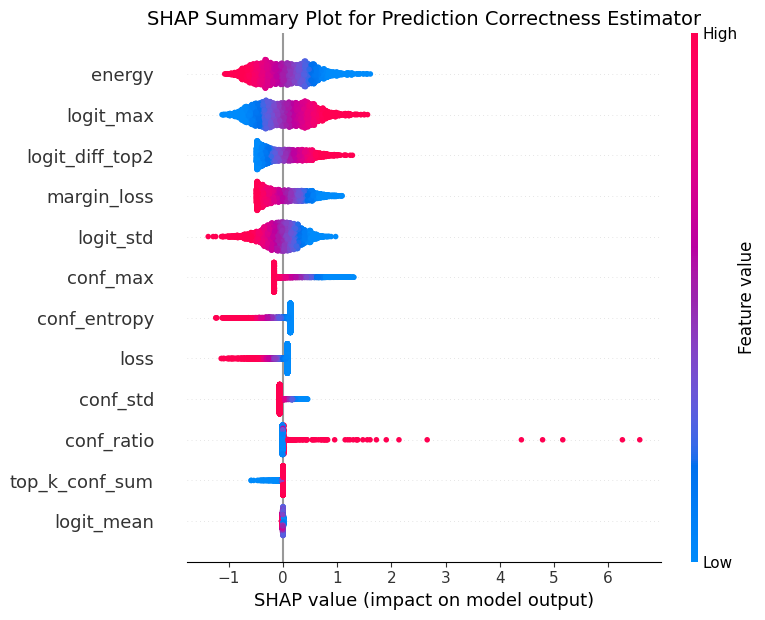

In [29]:
explainer = shap.Explainer(model, test_features)
shap_values = explainer(test_features)
# Create the summary plot
shap.summary_plot(shap_values, test_features, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot for Prediction Correctness Estimator", fontsize=14)
plt.tight_layout()
plt.show()

## Figure 1

In [19]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import scipy.stats as stats

cache_file = "suitability/results/features/fmow_ERM_last_0.pkl"

if os.path.exists(cache_file):
    with open(cache_file, "rb") as f:
        full_feature_dict = pickle.load(f)

splits_file = "suitability/results/split_indices/fmow_ood.pkl"

if os.path.exists(splits_file):
    with open(splits_file, "rb") as f:
        split_indices = pickle.load(f)

Dsf_features, Dsf_corr = full_feature_dict["id_val"]

print(split_indices.keys())
test_features, test_corr = full_feature_dict["test"]
test_features = test_features[split_indices[('test', "{'region': 'Europe'}")]]
test_corr = test_corr[split_indices[('test', "{'region': 'Europe'}")]]
print(test_features.shape, test_corr.shape, np.mean(test_corr))

user_features, user_corr = full_feature_dict["test"]
user_features = user_features[split_indices[('test', "{'region': 'Africa'}")]]
user_corr = user_corr[split_indices[('test', "{'region': 'Africa'}")]]
print(user_features.shape, user_corr.shape, np.mean(user_corr))

user_features_2, user_corr_2 = full_feature_dict["val"]
user_features_2 = user_features_2[split_indices[('val', "{'region': 'Americas', 'year': 2013}")]]
user_corr_2 = user_corr_2[split_indices[('val', "{'region': 'Americas', 'year': 2013}")]]
print(user_features_2.shape, user_corr_2.shape, np.mean(user_corr_2))

scaler = StandardScaler()
Dsf_features = scaler.fit_transform(Dsf_features)
test_features = scaler.transform(test_features)
user_features = scaler.transform(user_features)
user_features_2 = scaler.transform(user_features_2)

model = LogisticRegression(max_iter=1000)
user_model = CalibratedClassifierCV(model, method='sigmoid', cv=10)
test_model = CalibratedClassifierCV(model, method='sigmoid', cv=10)
user_model_2 = CalibratedClassifierCV(model, method='sigmoid', cv=10)

# Calibrate the model's probabilities
user_model.fit(user_features, user_corr)
test_model.fit(test_features, test_corr)
user_model_2.fit(user_features_2, user_corr_2)

# # Predict on the test set
test_corr_pred = test_model.predict(test_features)
test_prob = test_model.predict_proba(test_features)[:, 1]

user_corr_pred = user_model.predict(user_features)
user_prob = user_model.predict_proba(user_features)[:, 1]

user_corr_pred_2 = user_model_2.predict(user_features_2)
user_prob_2 = user_model_2.predict_proba(user_features_2)[:, 1]

print(f"Test corr pred: {np.mean(test_corr_pred)}, Test prob: {np.mean(test_prob)}")
print(f"User corr pred: {np.mean(user_corr_pred)}, User prob: {np.mean(user_prob)}")
print(f"User corr pred 2: {np.mean(user_corr_pred_2)}, User prob 2: {np.mean(user_prob_2)}")

dict_keys([('val', "{'year': [2013]}"), ('val', "{'year': [2014]}"), ('val', "{'year': [2015]}"), ('val', "{'region': ['Asia']}"), ('val', "{'region': ['Europe']}"), ('val', "{'region': ['Africa']}"), ('val', "{'region': ['Americas']}"), ('val', "{'region': ['Oceania']}"), ('val', "{'region': 'Europe', 'year': 2013}"), ('val', "{'region': 'Europe', 'year': 2014}"), ('val', "{'region': 'Europe', 'year': 2015}"), ('val', "{'region': 'Asia', 'year': 2013}"), ('val', "{'region': 'Asia', 'year': 2014}"), ('val', "{'region': 'Asia', 'year': 2015}"), ('val', "{'region': 'Americas', 'year': 2013}"), ('val', "{'region': 'Americas', 'year': 2014}"), ('val', "{'region': 'Americas', 'year': 2015}"), ('test', "{'year': 2016}"), ('test', "{'year': 2017}"), ('test', "{'region': 'Asia'}"), ('test', "{'region': 'Europe'}"), ('test', "{'region': 'Africa'}"), ('test', "{'region': 'Americas'}"), ('test', "{'region': 'Oceania'}"), ('test', "{'region': 'Europe', 'year': 2016}"), ('test', "{'region': 'Europe

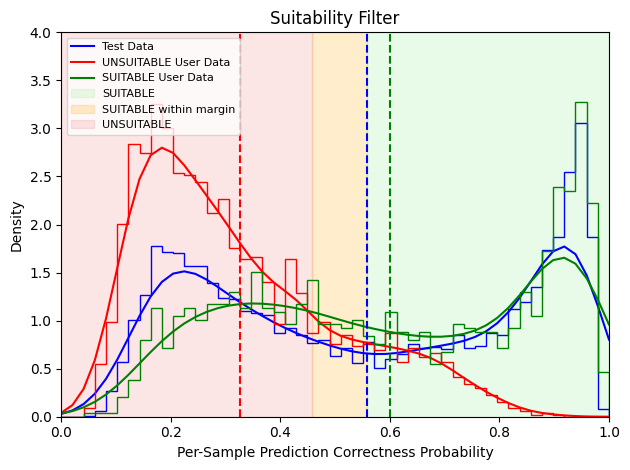

In [36]:
test_density = stats.gaussian_kde(test_prob)
_, x, _ = plt.hist(test_prob, bins=np.linspace(0, 1, 50), histtype='step', density=True, color='blue')
plt.plot(x, test_density(x), label=f"Test Data", color='blue')

user_density = stats.gaussian_kde(user_prob)
_, x, _ = plt.hist(user_prob, bins=np.linspace(0, 1, 50), histtype='step', density=True, color='red') 
plt.plot(x, user_density(x), label=f"UNSUITABLE User Data", color='red')

user_density_2 = stats.gaussian_kde(user_prob_2)
_, x, _ = plt.hist(user_prob_2, bins=np.linspace(0, 1, 50), histtype='step', density=True, color='green')
plt.plot(x, user_density_2(x), label=f"SUITABLE User Data", color='green')

plt.axvline(np.mean(user_prob), color='red', linestyle='--')
plt.axvline(np.mean(test_prob), color='blue', linestyle='--')
plt.axvline(np.mean(user_prob_2), color='green', linestyle='--')

plt.axvspan(np.mean(test_prob), 1, color='lightgreen', alpha=0.2, label='SUITABLE')
plt.axvspan(np.mean(test_prob) - 0.1, np.mean(test_prob), color='orange', alpha=0.2, label='SUITABLE within margin')
plt.axvspan(0, np.mean(test_prob) - 0.1, color='lightcoral', alpha=0.2, label='UNSUITABLE')

plt.xlabel("Per-Sample Prediction Correctness Probability")
plt.ylabel("Density")
plt.title("Suitability Filter")
plt.legend(loc='upper left', fontsize=8) #, bbox_to_anchor=(1, 1))
plt.ylim(0, 4)
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

## Splits table

In [11]:
import ast

cache_file_0 = "suitability/results/features/fmow_ERM_last_0.pkl"
cache_file_1 = "suitability/results/features/fmow_ERM_last_1.pkl"
cache_file_2 = "suitability/results/features/fmow_ERM_last_2.pkl"

split_dict = {
    "id_val": "id\_val",
    "id_test": "id\_test",
    "val": "val",
    "test": "test",
}

years_dict = {
    "[2002, 2003, 2004, 2005, 2006]": "2002-2006",
    "[2007, 2008, 2009]": "2007-2009",
    "[2010]": "2010",
    "[2011]": "2011",
    "[2012]": "2012",
    "[2013]": "2013",
    "[2014]": "2014",
    "[2015]": "2015",
    "[2016]": "2016",
    "[2017]": "2017",
}

latex_table = "\\begin{tabular}{lcccc}\n"
latex_table += "\\toprule\n"
latex_table += "Split & Year & Region & Num Samples & Accuracy \\\\\n"
latex_table += "\\midrule\n"

if os.path.exists(cache_file_0):
    with open(cache_file_0, "rb") as f:
        full_feature_dict_0 = pickle.load(f)
if os.path.exists(cache_file_1):
    with open(cache_file_1, "rb") as f:
        full_feature_dict_1 = pickle.load(f)
if os.path.exists(cache_file_2):
    with open(cache_file_2, "rb") as f:
        full_feature_dict_2 = pickle.load(f)

splits_file_ood = "suitability/results/split_indices/fmow_ood.pkl"
if os.path.exists(splits_file_ood):
    with open(splits_file_ood, "rb") as f:
        split_indices_ood = pickle.load(f)
splits_file_id = "suitability/results/split_indices/fmow_id.pkl"
if os.path.exists(splits_file_id):
    with open(splits_file_id, "rb") as f:
        split_indices_id = pickle.load(f)

for split, indices in split_indices_id.items():
    split_name, split_filter = split
    split_filter = ast.literal_eval(split_filter)
    row = f"{split_dict[split_name]} & "
    if "year" in split_filter:
        row += f"{years_dict[str(split_filter['year'])]} & "
    else:
        row += "All & "
    if "region" in split_filter:
        row += f"{split_filter['region'][0]} & "
    else:
        row += "All & "
    row += f"{len(indices)} & "
    acc_0 = 100*np.mean(full_feature_dict_0[split_name][1][indices])
    acc_1 = 100*np.mean(full_feature_dict_1[split_name][1][indices])
    acc_2 = 100*np.mean(full_feature_dict_2[split_name][1][indices])
    acc_values = np.array([acc_0, acc_1, acc_2])
    mean, se = np.mean(acc_values), stats.sem(acc_values)
    ci_half_width = se * stats.t.ppf(0.975, len(acc_values) - 1)
    row += f"${mean:.2f}\pm {ci_half_width:.2f}\%$ \\\\"
    latex_table += row + "\n"

latex_table += "\\midrule\n"

for split, indices in split_indices_ood.items():
    split_name, split_filter = split
    split_filter = ast.literal_eval(split_filter)
    row = f"{split_dict[split_name]} & "
    if "year" in split_filter:
        if type(split_filter["year"]) == int:
            row += f"{years_dict[str([split_filter['year']])]} & "
        else:
            row += f"{years_dict[str(split_filter['year'])]} & "
    else:
        row += "All & "
    if "region" in split_filter:
        if type(split_filter["region"]) == str:
            row += f"{split_filter['region']} & "
        else:
            row += f"{split_filter['region'][0]} & "
    else:
        row += "All & "
    row += f"{len(indices)} & "
    acc_0 = 100*np.mean(full_feature_dict_0[split_name][1][indices])
    acc_1 = 100*np.mean(full_feature_dict_1[split_name][1][indices])
    acc_2 = 100*np.mean(full_feature_dict_2[split_name][1][indices])
    acc_values = np.array([acc_0, acc_1, acc_2])
    mean, se = np.mean(acc_values), stats.sem(acc_values)
    ci_half_width = se * stats.t.ppf(0.975, len(acc_values) - 1)
    row += f"${mean:.2f}\pm {ci_half_width:.2f}\%$ \\\\"
    latex_table += row + "\n"

latex_table += "\\bottomrule\n\\end{tabular}\n"
print(latex_table)

\begin{tabular}{lcccc}
\toprule
Split & Year & Region & Num Samples & Accuracy \\
\midrule
id\_val & 2002-2006 & All & 1420 & $53.99\pm 1.32\%$ \\
id\_val & 2007-2009 & All & 1430 & $55.78\pm 0.70\%$ \\
id\_val & 2010 & All & 2459 & $62.60\pm 1.64\%$ \\
id\_val & 2011 & All & 2874 & $65.98\pm 1.25\%$ \\
id\_val & 2012 & All & 3300 & $64.03\pm 0.13\%$ \\
id\_val & All & Asia & 2693 & $62.42\pm 1.03\%$ \\
id\_val & All & Europe & 5268 & $59.88\pm 0.56\%$ \\
id\_val & All & Americas & 3076 & $63.85\pm 2.10\%$ \\
id\_test & 2002-2006 & All & 1473 & $51.39\pm 4.54\%$ \\
id\_test & 2007-2009 & All & 1423 & $57.25\pm 0.61\%$ \\
id\_test & 2010 & All & 2456 & $61.01\pm 0.41\%$ \\
id\_test & 2011 & All & 2837 & $65.03\pm 1.15\%$ \\
id\_test & 2012 & All & 3138 & $62.42\pm 1.36\%$ \\
id\_test & All & Asia & 2615 & $59.39\pm 1.94\%$ \\
id\_test & All & Europe & 5150 & $58.99\pm 0.51\%$ \\
id\_test & All & Americas & 3130 & $63.05\pm 1.39\%$ \\
\midrule
val & 2013 & All & 3850 & $60.29\pm 1.81\%$ 

In [ ]:
import ast

cache_file_0 = "suitability/results/features/civilcomments_ERM_last_0.pkl"
cache_file_1 = "suitability/results/features/civilcomments_ERM_last_1.pkl"
cache_file_2 = "suitability/results/features/civilcomments_ERM_last_2.pkl"

sens_dict = {
    "male": "Male",
    "female": "Female",
    "LGBTQ": "LGBTQ",
    "christian": "Christian",
    "muslim": "Muslim",
    "other_religions": "Other Religions",
    "black": "Black",
    "white": "White",
}    

latex_table = "\\begin{tabular}{lccc}\n"
latex_table += "\\toprule\n"
latex_table += "Split & Sensitive Attribute & Num Samples & Accuracy \\\\\n"
latex_table += "\\midrule\n"

if os.path.exists(cache_file_0):
    with open(cache_file_0, "rb") as f:
        full_feature_dict_0 = pickle.load(f)
if os.path.exists(cache_file_1):
    with open(cache_file_1, "rb") as f:
        full_feature_dict_1 = pickle.load(f)
if os.path.exists(cache_file_2):
    with open(cache_file_2, "rb") as f:
        full_feature_dict_2 = pickle.load(f)

splits_file = "suitability/results/split_indices/civilcomments.pkl"
if os.path.exists(splits_file):
    with open(splits_file, "rb") as f:
        split_indices = pickle.load(f)

for split, indices in split_indices.items():
    split_name, split_filter = split
    split_filter = ast.literal_eval(split_filter)
    row = f"{split_name} & "
    row += f"{sens_dict[str(split_filter['sensitive'])]} & "
    row += f"{len(indices)} & "
    acc_0 = 100*np.mean(full_feature_dict_0[split_name][1][indices])
    acc_1 = 100*np.mean(full_feature_dict_1[split_name][1][indices])
    acc_2 = 100*np.mean(full_feature_dict_2[split_name][1][indices])
    acc_values = np.array([acc_0, acc_1, acc_2])
    mean, se = np.mean(acc_values), stats.sem(acc_values)
    ci_half_width = se * stats.t.ppf(0.975, len(acc_values) - 1)
    row += f"${mean:.2f}\pm {ci_half_width:.2f}\%$ \\\\"
    latex_table += row + "\n"

latex_table += "\\bottomrule\n\\end{tabular}\n"
print(latex_table)

\begin{tabular}{lccc}
\toprule
Split & Sensitive Attribute & Num Samples & Accuracy \\
\midrule
val & Male & 4765 & $89.31\pm 0.22\%$ \\
val & Female & 5891 & $90.09\pm 0.68\%$ \\
val & LGBTQ & 1457 & $80.00\pm 0.97\%$ \\
val & Christian & 4550 & $92.72\pm 0.17\%$ \\
val & Muslim & 2110 & $81.52\pm 1.39\%$ \\
val & Other Religions & 986 & $85.87\pm 0.77\%$ \\
val & Black & 1652 & $77.85\pm 1.14\%$ \\
val & White & 2867 & $77.26\pm 0.76\%$ \\
test & Male & 14295 & $88.84\pm 0.16\%$ \\
test & Female & 16449 & $90.02\pm 0.18\%$ \\
test & LGBTQ & 4426 & $79.78\pm 0.68\%$ \\
test & Christian & 13361 & $92.22\pm 0.25\%$ \\
test & Muslim & 6982 & $82.65\pm 0.58\%$ \\
test & Other Religions & 3500 & $88.18\pm 0.58\%$ \\
test & Black & 4872 & $78.39\pm 0.68\%$ \\
test & White & 7969 & $79.88\pm 0.47\%$ \\
\bottomrule
\end{tabular}



In [12]:
import ast

cache_file_0 = "suitability/results/features/rxrx1_ERM_last_0.pkl"
cache_file_1 = "suitability/results/features/rxrx1_ERM_last_1.pkl"
cache_file_2 = "suitability/results/features/rxrx1_ERM_last_2.pkl"

sens_dict = {
    "male": "Male",
    "female": "Female",
    "LGBTQ": "LGBTQ",
    "christian": "Christian",
    "muslim": "Muslim",
    "other_religions": "Other Religions",
    "black": "Black",
    "white": "White",
}    

latex_table = "\\begin{tabular}{lccc}\n"
latex_table += "\\toprule\n"
latex_table += "Split & Cell Type & Num Samples & Accuracy \\\\\n"
latex_table += "\\midrule\n"

if os.path.exists(cache_file_0):
    with open(cache_file_0, "rb") as f:
        full_feature_dict_0 = pickle.load(f)
if os.path.exists(cache_file_1):
    with open(cache_file_1, "rb") as f:
        full_feature_dict_1 = pickle.load(f)
if os.path.exists(cache_file_2):
    with open(cache_file_2, "rb") as f:
        full_feature_dict_2 = pickle.load(f)

splits_file = "suitability/results/split_indices/rxrx1.pkl"
if os.path.exists(splits_file):
    with open(splits_file, "rb") as f:
        split_indices = pickle.load(f)

for split, indices in split_indices.items():
    split_name, split_filter = split
    split_filter = ast.literal_eval(split_filter)
    row = f"{split_name} & "
    row += f"{split_filter['cell_type']} & "
    row += f"{len(indices)} & "
    acc_0 = 100*np.mean(full_feature_dict_0[split_name][1][indices])
    acc_1 = 100*np.mean(full_feature_dict_1[split_name][1][indices])
    acc_2 = 100*np.mean(full_feature_dict_2[split_name][1][indices])
    acc_values = np.array([acc_0, acc_1, acc_2])
    mean, se = np.mean(acc_values), stats.sem(acc_values)
    ci_half_width = se * stats.t.ppf(0.975, len(acc_values) - 1)
    row += f"${mean:.2f}\pm {ci_half_width:.2f}\%$ \\\\"
    latex_table += row + "\n"

latex_table += "\\bottomrule\n\\end{tabular}\n"
print(latex_table)

\begin{tabular}{lccc}
\toprule
Split & Cell Type & Num Samples & Accuracy \\
\midrule
val & HEPG2 & 2462 & $21.01\pm 1.77\%$ \\
val & HUVEC & 2464 & $36.85\pm 0.10\%$ \\
val & RPE & 2464 & $16.44\pm 0.96\%$ \\
val & U2OS & 2464 & $2.27\pm 0.30\%$ \\
id_test & HEPG2 & 8622 & $25.39\pm 1.43\%$ \\
id_test & HUVEC & 19671 & $50.30\pm 1.24\%$ \\
id_test & RPE & 8623 & $23.86\pm 1.17\%$ \\
id_test & U2OS & 3696 & $17.00\pm 0.98\%$ \\
test & HEPG2 & 7388 & $22.63\pm 1.28\%$ \\
test & HUVEC & 17244 & $39.99\pm 1.13\%$ \\
test & RPE & 7360 & $21.32\pm 0.41\%$ \\
test & U2OS & 2440 & $8.96\pm 1.78\%$ \\
\bottomrule
\end{tabular}



## Figure 3

In [67]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import scipy.stats as stats
from suitability.filter.tests import non_inferiority_ttest
import ast

cache_file = "suitability/results/features/fmow_ERM_last_0.pkl"
if os.path.exists(cache_file):
    with open(cache_file, "rb") as f:
        full_feature_dict = pickle.load(f)

splits_file_ood = "suitability/results/split_indices/fmow_ood.pkl"
if os.path.exists(splits_file_ood):
    with open(splits_file_ood, "rb") as f:
        split_indices_ood = pickle.load(f)
splits_file_id = "suitability/results/split_indices/fmow_id.pkl"
if os.path.exists(splits_file_id):
    with open(splits_file_id, "rb") as f:
        split_indices_id = pickle.load(f)

sf_features, sf_corr = full_feature_dict["id_val"]

sf_features = sf_features[split_indices_id[('id_val', "{'region': ['Europe']}")]]
sf_corr = sf_corr[split_indices_id[('id_val', "{'region': ['Europe']}")]]
print(sf_features.shape, sf_corr.shape, np.mean(sf_corr))

test_features, test_corr = full_feature_dict["id_test"]
test_features = test_features[split_indices_id[('id_test', "{'region': ['Europe']}")]]
test_corr = test_corr[split_indices_id[('id_test', "{'region': ['Europe']}")]]
print(test_features.shape, test_corr.shape, np.mean(test_corr))

del split_indices_id[('id_val', "{'region': ['Europe']}")] 
del split_indices_id[('id_test', "{'region': ['Europe']}")]

user_indices = {**split_indices_id, **split_indices_ood} #  

scaler = StandardScaler()
sf_features = scaler.fit_transform(sf_features)
test_features = scaler.transform(test_features)

model = LogisticRegression(max_iter=1000)
model.fit(sf_features, sf_corr)
calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv="prefit")
calibrated_model.fit(sf_features, sf_corr)

test_prob = calibrated_model.predict_proba(test_features)[:, 1]
margin = 0.05

actual_acc = []
pred_acc = []
pred_prob_mean = []
p_val = []

cal_pred_acc = []
cal_pred_prob_mean = []
cal_p_val = []

for split, indices in user_indices.items():
    split_name, split_filter = split
    split_filter = ast.literal_eval(split_filter)
    user_features = full_feature_dict[split_name][0][indices]
    user_corr = full_feature_dict[split_name][1][indices]
    actual_acc.append(np.mean(user_corr))

    user_features = scaler.transform(user_features)
    user_corr_pred = calibrated_model.predict(user_features)
    user_prob = calibrated_model.predict_proba(user_features)[:, 1]
    pred_acc.append(np.mean(user_corr_pred))
    pred_prob_mean.append(np.mean(user_prob))
    test = non_inferiority_ttest(test_prob, user_prob, margin)
    p_val.append(test["p_value"])

    user_calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv="prefit")
    user_calibrated_model.fit(user_features, user_corr)
    user_corr_pred = user_calibrated_model.predict(user_features)
    user_prob = user_calibrated_model.predict_proba(user_features)[:, 1]
    cal_pred_acc.append(np.mean(user_corr_pred))
    cal_pred_prob_mean.append(np.mean(user_prob))
    test = non_inferiority_ttest(test_prob, user_prob, margin)
    cal_p_val.append(test["p_value"])

(5268, 12) (5268,) 0.5975702353834472
(5150, 12) (5150,) 0.5877669902912621


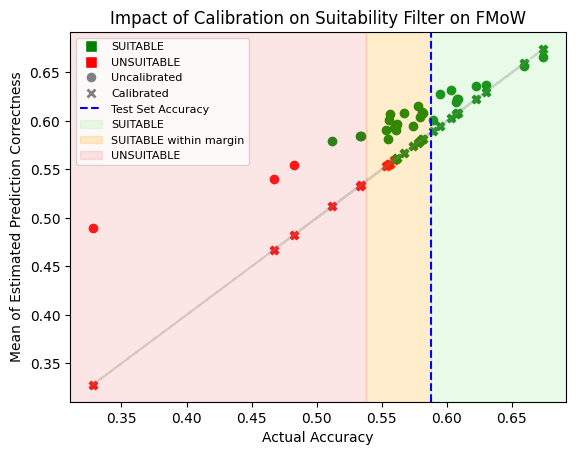

In [59]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

actual_acc = np.array(actual_acc[15:])
pred_acc = np.array(pred_acc[15:])
pred_prob_mean = np.array(pred_prob_mean[15:])
cal_pred_prob_mean = np.array(cal_pred_prob_mean[15:])
p_val = np.array(p_val[15:])
cal_p_val = np.array(cal_p_val[15:])

suitable = np.array(p_val) < 0.05
cal_suitable = np.array(cal_p_val) < 0.05

plt.plot(actual_acc, actual_acc, color='grey', alpha=0.3, linestyle='--')
plt.scatter(actual_acc[~suitable], pred_prob_mean[~suitable], color='red', label='UNSUITABLE uncalibrated', marker='o')
plt.scatter(actual_acc[suitable], pred_prob_mean[suitable], color='green', label='SUITABLE uncalibrated', marker='o')
plt.scatter(actual_acc[~cal_suitable], cal_pred_prob_mean[~cal_suitable], color='red', label='UNSUITABLE calibrated', marker='X')
plt.scatter(actual_acc[cal_suitable], cal_pred_prob_mean[cal_suitable], color='green', label='SUITABLE calibrated', marker='X')

plt.axvline(np.mean(test_corr), color='blue', linestyle='--')
# plt.axhline(np.mean(test_corr), color='blue', linestyle='--')
plt.axvspan(np.mean(test_corr), 1, color='lightgreen', alpha=0.2, label='SUITABLE')
plt.axvspan(np.mean(test_corr) - margin, np.mean(test_corr), color='orange', alpha=0.2, label='SUITABLE within margin')
plt.axvspan(0, np.mean(test_corr) - margin, color='lightcoral', alpha=0.2, label='UNSUITABLE')

legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor='green', markersize=8, label='SUITABLE'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markersize=8, label='UNSUITABLE'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=8, label='Uncalibrated'),
    Line2D([0], [0], marker='X', color='w', markerfacecolor='grey', markersize=8, label='Calibrated'),
    Line2D([0], [0], color='blue', linestyle='--', label='Test Set Accuracy'),
    Patch(color='lightgreen', alpha=0.2, label='SUITABLE'),
    Patch(color='orange', alpha=0.2, label='SUITABLE within margin'),
    Patch(color='lightcoral', alpha=0.2, label='UNSUITABLE')
]

plt.xlabel("Actual Accuracy")
plt.ylabel("Mean of Estimated Prediction Correctness")
plt.title("Impact of Calibration on Suitability Filter on FMoW OOD")
plt.legend(handles=legend_elements, loc='upper left', fontsize=8) #, bbox_to_anchor=(1, 1))

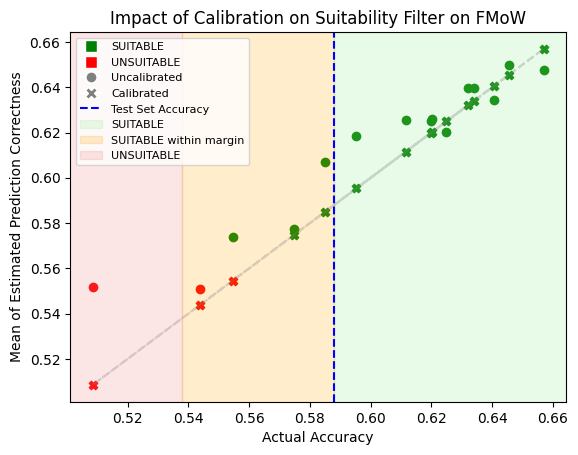

In [61]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

actual_acc = np.array(actual_acc[:15])
pred_acc = np.array(pred_acc[:15])
pred_prob_mean = np.array(pred_prob_mean[:15])
cal_pred_prob_mean = np.array(cal_pred_prob_mean[:15])
p_val = np.array(p_val[:15])
cal_p_val = np.array(cal_p_val[:15])

suitable = np.array(p_val) < 0.05
cal_suitable = np.array(cal_p_val) < 0.05

plt.plot(actual_acc, actual_acc, color='grey', alpha=0.3, linestyle='--')
plt.scatter(actual_acc[~suitable], pred_prob_mean[~suitable], color='red', label='UNSUITABLE uncalibrated', marker='o')
plt.scatter(actual_acc[suitable], pred_prob_mean[suitable], color='green', label='SUITABLE uncalibrated', marker='o')
plt.scatter(actual_acc[~cal_suitable], cal_pred_prob_mean[~cal_suitable], color='red', label='UNSUITABLE calibrated', marker='X')
plt.scatter(actual_acc[cal_suitable], cal_pred_prob_mean[cal_suitable], color='green', label='SUITABLE calibrated', marker='X')

plt.axvline(np.mean(test_corr), color='blue', linestyle='--')
# plt.axhline(np.mean(test_corr), color='blue', linestyle='--')
plt.axvspan(np.mean(test_corr), 1, color='lightgreen', alpha=0.2, label='SUITABLE')
plt.axvspan(np.mean(test_corr) - margin, np.mean(test_corr), color='orange', alpha=0.2, label='SUITABLE within margin')
plt.axvspan(0, np.mean(test_corr) - margin, color='lightcoral', alpha=0.2, label='UNSUITABLE')

legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor='green', markersize=8, label='SUITABLE'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markersize=8, label='UNSUITABLE'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=8, label='Uncalibrated'),
    Line2D([0], [0], marker='X', color='w', markerfacecolor='grey', markersize=8, label='Calibrated'),
    Line2D([0], [0], color='blue', linestyle='--', label='Test Set Accuracy'),
    Patch(color='lightgreen', alpha=0.2, label='SUITABLE'),
    Patch(color='orange', alpha=0.2, label='SUITABLE within margin'),
    Patch(color='lightcoral', alpha=0.2, label='UNSUITABLE')
]

plt.xlabel("Actual Accuracy")
plt.ylabel("Mean of Estimated Prediction Correctness")
plt.title("Impact of Calibration on Suitability Filter on FMoW")
plt.legend(handles=legend_elements, loc='upper left', fontsize=8) #, bbox_to_anchor=(1, 1))

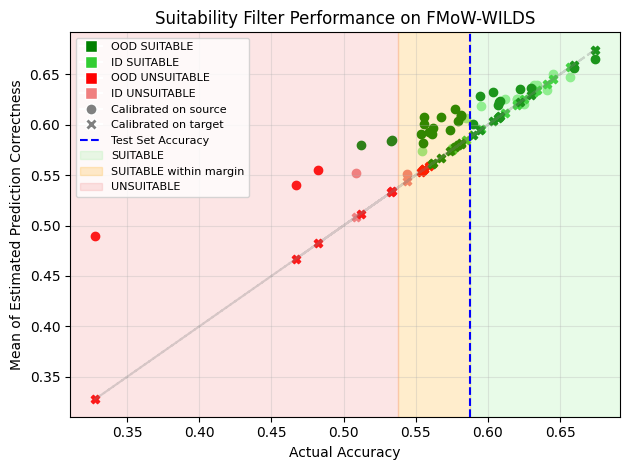

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

actual_acc = np.array(actual_acc)
pred_acc = np.array(pred_acc)
pred_prob_mean = np.array(pred_prob_mean)
cal_pred_prob_mean = np.array(cal_pred_prob_mean)
p_val = np.array(p_val)
cal_p_val = np.array(cal_p_val)

# Split into ID and OOD data
actual_acc_ID, actual_acc_OOD = actual_acc[:15], actual_acc[15:]
pred_prob_mean_ID, pred_prob_mean_OOD = pred_prob_mean[:15], pred_prob_mean[15:]
cal_pred_prob_mean_ID, cal_pred_prob_mean_OOD = cal_pred_prob_mean[:15], cal_pred_prob_mean[15:]
p_val_ID, p_val_OOD = p_val[:15], p_val[15:]
cal_p_val_ID, cal_p_val_OOD = cal_p_val[:15], cal_p_val[15:]

# Determine suitability
suitable_ID = p_val_ID < 0.05
cal_suitable_ID = cal_p_val_ID < 0.05
suitable_OOD = p_val_OOD < 0.05
cal_suitable_OOD = cal_p_val_OOD < 0.05

# Plot setup
plt.figure()

# Add diagonal reference line
plt.plot(actual_acc_OOD, actual_acc_OOD, color='grey', alpha=0.3, linestyle='--')

# ID data points
plt.scatter(actual_acc_ID[~suitable_ID], pred_prob_mean_ID[~suitable_ID], color='lightcoral', label='ID UNSUITABLE uncalibrated', marker='o')
plt.scatter(actual_acc_ID[suitable_ID], pred_prob_mean_ID[suitable_ID], color='lightgreen', label='ID SUITABLE uncalibrated', marker='o')
plt.scatter(actual_acc_ID[~cal_suitable_ID], cal_pred_prob_mean_ID[~cal_suitable_ID], color='lightcoral', label='ID UNSUITABLE calibrated', marker='X')
plt.scatter(actual_acc_ID[cal_suitable_ID], cal_pred_prob_mean_ID[cal_suitable_ID], color='limegreen', label='ID SUITABLE calibrated', marker='X')

# OOD data points
plt.scatter(actual_acc_OOD[~suitable_OOD], pred_prob_mean_OOD[~suitable_OOD], color='red', label='OOD UNSUITABLE uncalibrated', marker='o')
plt.scatter(actual_acc_OOD[suitable_OOD], pred_prob_mean_OOD[suitable_OOD], color='green', label='OOD SUITABLE uncalibrated', marker='o')
plt.scatter(actual_acc_OOD[~cal_suitable_OOD], cal_pred_prob_mean_OOD[~cal_suitable_OOD], color='red', label='OOD UNSUITABLE calibrated', marker='X')
plt.scatter(actual_acc_OOD[cal_suitable_OOD], cal_pred_prob_mean_OOD[cal_suitable_OOD], color='green', label='OOD SUITABLE calibrated', marker='X')

# Add vertical regions and test accuracy line
plt.axvline(np.mean(test_corr), color='blue', linestyle='--')
# plt.axhline(np.mean(test_corr), color='blue', linestyle='--')
plt.axvspan(np.mean(test_corr), 1, color='lightgreen', alpha=0.2, label='SUITABLE')
plt.axvspan(np.mean(test_corr) - margin, np.mean(test_corr), color='orange', alpha=0.2, label='SUITABLE within margin')
plt.axvspan(0, np.mean(test_corr) - margin, color='lightcoral', alpha=0.2, label='UNSUITABLE')

# Legend elements
legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor='green', markersize=8, label='OOD SUITABLE'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='limegreen', markersize=8, label='ID SUITABLE'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markersize=8, label='OOD UNSUITABLE'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='lightcoral', markersize=8, label='ID UNSUITABLE'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=8, label='Calibrated on source'),
    Line2D([0], [0], marker='X', color='w', markerfacecolor='grey', markersize=8, label='Calibrated on target'),
    Line2D([0], [0], color='blue', linestyle='--', label='Test Set Accuracy'),
    Patch(color='lightgreen', alpha=0.2, label='SUITABLE'),
    Patch(color='orange', alpha=0.2, label='SUITABLE within margin'),
    Patch(color='lightcoral', alpha=0.2, label='UNSUITABLE')
]

plt.xlabel("Actual Accuracy")
plt.ylabel("Mean of Estimated Prediction Correctness")
plt.title("Suitability Filter Performance on FMoW-WILDS")
plt.legend(handles=legend_elements, loc='upper left', fontsize=8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [9]:
res = pd.read_csv('suitability/results/data_splits/fmow_ERM_0_last.csv')
res.sort_values(by='accuracy', inplace=True)
res.iloc[30]

split           id_test
year               2008
region              ALL
num_samples         298
accuracy       0.580537
Name: 22, dtype: object

In [11]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import scipy.stats as stats
from suitability.filter.tests import non_inferiority_ttest
import ast

cache_file = "suitability/results/features/rxrx1_ERM_last_1.pkl"
if os.path.exists(cache_file):
    with open(cache_file, "rb") as f:
        full_feature_dict = pickle.load(f)

splits_file = "suitability/results/split_indices/rxrx1.pkl"
if os.path.exists(splits_file):
    with open(splits_file, "rb") as f:
        split_indices = pickle.load(f)

print(split_indices.keys())

sf_features, sf_corr = full_feature_dict["id_test"]
sf_features = sf_features[split_indices[('id_test', "{'cell_type': 'HEPG2'}")]]
sf_corr = sf_corr[split_indices[('id_test', "{'cell_type': 'HEPG2'}")]]
print(sf_features.shape, sf_corr.shape, np.mean(sf_corr))

test_features, test_corr = full_feature_dict["id_test"]
test_features = test_features[split_indices[('id_test', "{'cell_type': 'RPE'}")]]
test_corr = test_corr[split_indices[('id_test', "{'cell_type': 'RPE'}")]]
print(test_features.shape, test_corr.shape, np.mean(test_corr))

del split_indices[('id_test', "{'cell_type': 'HEPG2'}")] 
del split_indices[('id_test', "{'cell_type': 'RPE'}")]
del split_indices[('id_test', "{'cell_type': 'HUVEC'}")] 
del split_indices[('id_test', "{'cell_type': 'U2OS'}")]


user_indices = {**split_indices} # **split_indices_id, 

scaler = StandardScaler()
sf_features = scaler.fit_transform(sf_features)
test_features = scaler.transform(test_features)

model = LogisticRegression(max_iter=1000)
model.fit(sf_features, sf_corr)
calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv="prefit")
calibrated_model.fit(sf_features, sf_corr)

test_prob = calibrated_model.predict_proba(test_features)[:, 1]
margin = 0.02

actual_acc = []
pred_acc = []
pred_prob_mean = []
p_val = []

cal_pred_acc = []
cal_pred_prob_mean = []
cal_p_val = []

for split, indices in user_indices.items():
    split_name, split_filter = split
    split_filter = ast.literal_eval(split_filter)
    user_features = full_feature_dict[split_name][0][indices]
    user_corr = full_feature_dict[split_name][1][indices]
    actual_acc.append(np.mean(user_corr))

    user_features = scaler.transform(user_features)
    user_corr_pred = calibrated_model.predict(user_features)
    user_prob = calibrated_model.predict_proba(user_features)[:, 1]
    pred_acc.append(np.mean(user_corr_pred))
    pred_prob_mean.append(np.mean(user_prob))
    test = non_inferiority_ttest(test_prob, user_prob, margin)
    p_val.append(test["p_value"])

    user_calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv="prefit")
    user_calibrated_model.fit(user_features, user_corr)
    user_corr_pred = user_calibrated_model.predict(user_features)
    user_prob = user_calibrated_model.predict_proba(user_features)[:, 1]
    cal_pred_acc.append(np.mean(user_corr_pred))
    cal_pred_prob_mean.append(np.mean(user_prob))
    test = non_inferiority_ttest(test_prob, user_prob, margin)
    cal_p_val.append(test["p_value"])

dict_keys([('val', "{'cell_type': 'HEPG2'}"), ('val', "{'cell_type': 'HUVEC'}"), ('val', "{'cell_type': 'RPE'}"), ('val', "{'cell_type': 'U2OS'}"), ('id_test', "{'cell_type': 'HEPG2'}"), ('id_test', "{'cell_type': 'HUVEC'}"), ('id_test', "{'cell_type': 'RPE'}"), ('id_test', "{'cell_type': 'U2OS'}"), ('test', "{'cell_type': 'HEPG2'}"), ('test', "{'cell_type': 'HUVEC'}"), ('test', "{'cell_type': 'RPE'}"), ('test', "{'cell_type': 'U2OS'}")])
(8622, 12) (8622,) 0.2603804221758293
(8623, 12) (8623,) 0.2383161312768178


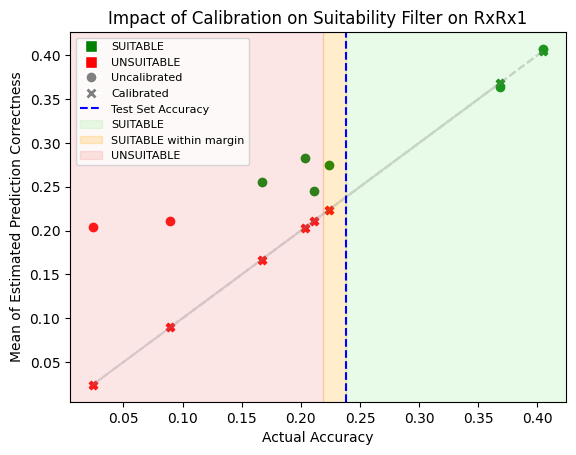

In [13]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

actual_acc = np.array(actual_acc)
pred_acc = np.array(pred_acc)
pred_prob_mean = np.array(pred_prob_mean)
cal_pred_prob_mean = np.array(cal_pred_prob_mean)

suitable = np.array(p_val) < 0.05
cal_suitable = np.array(cal_p_val) < 0.05

plt.plot(actual_acc, actual_acc, color='grey', alpha=0.3, linestyle='--')
plt.scatter(actual_acc[~suitable], pred_prob_mean[~suitable], color='red', label='UNSUITABLE uncalibrated', marker='o')
plt.scatter(actual_acc[suitable], pred_prob_mean[suitable], color='green', label='SUITABLE uncalibrated', marker='o')
plt.scatter(actual_acc[~cal_suitable], cal_pred_prob_mean[~cal_suitable], color='red', label='UNSUITABLE calibrated', marker='X')
plt.scatter(actual_acc[cal_suitable], cal_pred_prob_mean[cal_suitable], color='green', label='SUITABLE calibrated', marker='X')

plt.axvline(np.mean(test_corr), color='blue', linestyle='--')
# plt.axhline(np.mean(test_corr), color='blue', linestyle='--')
plt.axvspan(np.mean(test_corr), 1, color='lightgreen', alpha=0.2, label='SUITABLE')
plt.axvspan(np.mean(test_corr) - margin, np.mean(test_corr), color='orange', alpha=0.2, label='SUITABLE within margin')
plt.axvspan(0, np.mean(test_corr) - margin, color='lightcoral', alpha=0.2, label='UNSUITABLE')

legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor='green', markersize=8, label='SUITABLE'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markersize=8, label='UNSUITABLE'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=8, label='Uncalibrated'),
    Line2D([0], [0], marker='X', color='w', markerfacecolor='grey', markersize=8, label='Calibrated'),
    Line2D([0], [0], color='blue', linestyle='--', label='Test Set Accuracy'),
    Patch(color='lightgreen', alpha=0.2, label='SUITABLE'),
    Patch(color='orange', alpha=0.2, label='SUITABLE within margin'),
    Patch(color='lightcoral', alpha=0.2, label='UNSUITABLE')
]

plt.xlabel("Actual Accuracy")
plt.ylabel("Mean of Estimated Prediction Correctness")
plt.title("Impact of Calibration on Suitability Filter on RxRx1")
plt.legend(handles=legend_elements, loc='upper left', fontsize=8) #, bbox_to_anchor=(1, 1))

## CivilComments and RxRx1 Evals

In [32]:
data = get_agg_results_df("civilcomments", "id")
display(data)

,feature_subset,ROC AUC,ROC AUC MoE,PR AUC,PR AUC MoE,Accuracy,Accuracy MoE,FPR,FPR MoE,Accuracy@0.01,Accuracy@0.01 MoE,FPR@0.01,FPR@0.01 MoE,Accuracy@0.001,Accuracy@0.001 MoE,FPR@0.001,FPR@0.001 MoE
7,[7],0.996429,0.007243,0.969184,0.063550,0.914286,0.032698,0.000000,0.000000,0.895833,0.027385,0.000000,0.00000,0.895833,0.027385,0.0,0.0
9,[9],0.996240,0.006905,0.966739,0.063249,0.917956,0.087367,0.001543,0.006640,0.915278,0.092627,0.000000,0.00000,0.905952,0.058533,0.0,0.0
0,[0],0.996560,0.007273,0.970409,0.063463,0.917956,0.037263,0.000000,0.000000,0.895833,0.027385,0.000000,0.00000,0.895833,0.027385,0.0,0.0
1,[1],0.996560,0.007273,0.970409,0.063463,0.917956,0.037263,0.000000,0.000000,0.895833,0.027385,0.000000,0.00000,0.895833,0.027385,0.0,0.0
2,[2],0.996766,0.007452,0.972458,0.062294,0.923313,0.032516,0.000000,0.000000,0.905456,0.056627,0.000000,0.00000,0.895833,0.027385,0.0,0.0
5,[5],0.997285,0.008909,0.976222,0.077679,0.926389,0.083020,0.000000,0.000000,0.911111,0.072700,0.000000,0.00000,0.904167,0.051753,0.0,0.0
6,[6],0.997285,0.008909,0.976222,0.077679,0.926389,0.083020,0.000000,0.000000,0.911111,0.072700,0.000000,0.00000,0.904167,0.051753,0.0,0.0
8,[8],0.997285,0.008909,0.976222,0.077679,0.926389,0.083020,0.000000,0.000000,0.911111,0.072700,0.000000,0.00000,0.904167,0.051753,0.0,0.0
10,[11],0.997311,0.008679,0.976700,0.075282,0.927877,0.087610,0.001543,0.006640,0.916468,0.078052,0.000000,0.00000,0.905556,0.057007,0.0,0.0
4,[4],0.997317,0.008755,0.976610,0.076188,0.928373,0.082518,0.001323,0.005691,0.913889,0.073019,0.000000,0.00000,0.905556,0.057007,0.0,0.0


In [33]:
data = get_agg_results_df("rxrx1", "ood")
display(data)

,feature_subset,ROC AUC,ROC AUC MoE,PR AUC,PR AUC MoE,Accuracy,Accuracy MoE,FPR,FPR MoE,Accuracy@0.01,Accuracy@0.01 MoE,FPR@0.01,FPR@0.01 MoE,Accuracy@0.001,Accuracy@0.001 MoE,FPR@0.001,FPR@0.001 MoE
3,[3],0.017522,0.040509,0.225000,0.071711,0.191468,0.286418,0.749100,0.384518,0.194444,0.293002,0.745176,0.393197,0.232341,0.311874,0.696222,0.421837
5,[5],0.739326,0.275427,0.622674,0.291794,0.599008,0.553803,0.380826,0.755629,0.641667,0.502403,0.326385,0.695628,0.663095,0.478426,0.299034,0.667786
9,[9],0.994029,0.008213,0.976382,0.039719,0.824008,0.135620,0.000000,0.000000,0.800198,0.123007,0.000000,0.000000,0.782738,0.102444,0.000000,0.000000
10,[10],0.997255,0.009649,0.989410,0.038729,0.929563,0.255770,0.087737,0.315143,0.941071,0.216414,0.073371,0.266720,0.957143,0.148544,0.053472,0.182791
6,[6],0.996954,0.007179,0.989130,0.027210,0.944048,0.048683,0.000000,0.000000,0.910317,0.068472,0.000000,0.000000,0.900000,0.071711,0.000000,0.000000
8,[8],0.996954,0.007179,0.989130,0.027210,0.944048,0.048683,0.000000,0.000000,0.910317,0.068472,0.000000,0.000000,0.900000,0.071711,0.000000,0.000000
0,[0],0.997595,0.006211,0.991171,0.024852,0.975000,0.071711,0.031381,0.087740,0.978770,0.055491,0.026717,0.067673,0.972421,0.040719,0.013808,0.028700
1,[1],0.997670,0.005383,0.991332,0.022283,0.975000,0.071711,0.031381,0.087740,0.975198,0.070857,0.031136,0.086683,0.974405,0.048885,0.015623,0.025175
2,[2],0.998061,0.003946,0.992637,0.016947,0.975000,0.071711,0.031381,0.087740,0.975000,0.071711,0.031381,0.087740,0.981548,0.043539,0.023281,0.052887
4,[4],0.997271,0.008427,0.989710,0.033299,0.975000,0.071711,0.031381,0.087740,0.975000,0.071711,0.031381,0.087740,0.975000,0.071711,0.031381,0.087740


In [34]:
data = get_agg_results_df("rxrx1", "id")
display(data)

,feature_subset,ROC AUC,ROC AUC MoE,PR AUC,PR AUC MoE,Accuracy,Accuracy MoE,FPR,FPR MoE,Accuracy@0.01,Accuracy@0.01 MoE,FPR@0.01,FPR@0.01 MoE,Accuracy@0.001,Accuracy@0.001 MoE,FPR@0.001,FPR@0.001 MoE
3,[3],0.007143,3.073323e-02,0.25,0.000000e+00,0.161111,0.28182,0.785185,0.375759,0.172222,0.299512,0.77037,0.399349,0.177778,0.310747,0.762963,0.41433
0,[0],1.000000,0.000000e+00,1.00,0.000000e+00,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.00000
1,[1],1.000000,0.000000e+00,1.00,0.000000e+00,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.00000
2,[2],1.000000,0.000000e+00,1.00,0.000000e+00,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.00000
4,[4],1.000000,0.000000e+00,1.00,0.000000e+00,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.00000
5,[5],1.000000,0.000000e+00,1.00,0.000000e+00,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.994841,0.022196,0.000000,0.00000
6,[6],1.000000,1.950163e-16,1.00,1.950163e-16,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.00000
7,[7],1.000000,0.000000e+00,1.00,0.000000e+00,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.00000
8,[8],1.000000,1.950163e-16,1.00,1.950163e-16,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.00000
9,[9],1.000000,0.000000e+00,1.00,1.950163e-16,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.00000


In [35]:
data = get_agg_results_df("fmow", "ood")
display(data)

,feature_subset,ROC AUC,ROC AUC MoE,PR AUC,PR AUC MoE,Accuracy,Accuracy MoE,FPR,FPR MoE,Accuracy@0.01,Accuracy@0.01 MoE,FPR@0.01,FPR@0.01 MoE,Accuracy@0.001,Accuracy@0.001 MoE,FPR@0.001,FPR@0.001 MoE
5,[5],0.323551,0.256056,0.137291,0.019164,0.282593,0.163487,0.811626,0.166212,0.315873,0.201116,0.738904,0.201261,0.359259,0.197006,0.642931,0.193587
3,[3],0.845237,0.193489,0.698076,0.175383,0.616720,0.205103,0.446097,0.267909,0.719947,0.182198,0.302060,0.197299,0.818095,0.106071,0.158178,0.082292
9,[9],0.905235,0.049977,0.711237,0.101588,0.836349,0.064149,0.001112,0.004784,0.826243,0.058051,0.000000,0.000000,0.818677,0.058182,0.000000,0.000000
10,[10],0.915567,0.005216,0.772601,0.096555,0.867037,0.044314,0.026082,0.056857,0.868413,0.053062,0.002811,0.011685,0.842804,0.055206,0.000327,0.001407
7,[7],0.943796,0.013656,0.831338,0.118067,0.883492,0.034413,0.011798,0.022841,0.855450,0.028691,0.000916,0.003940,0.836508,0.028360,0.000916,0.003940
0,[0],0.948403,0.014892,0.842168,0.121049,0.883545,0.042295,0.010572,0.019809,0.856561,0.033010,0.000916,0.003940,0.839153,0.035289,0.000916,0.003940
6,[6],0.975625,0.014058,0.917137,0.073860,0.888519,0.026912,0.005454,0.011462,0.859524,0.044399,0.000000,0.000000,0.844392,0.052979,0.000000,0.000000
8,[8],0.975626,0.014064,0.917145,0.073863,0.888519,0.026912,0.005454,0.011462,0.859524,0.044399,0.000000,0.000000,0.844444,0.053167,0.000000,0.000000
1,[1],0.952090,0.013090,0.853667,0.107841,0.889101,0.039538,0.009660,0.018968,0.860741,0.042116,0.000916,0.003940,0.841905,0.034898,0.000720,0.003096
2,[2],0.957313,0.006781,0.871985,0.077783,0.891164,0.030534,0.010897,0.019918,0.872011,0.052019,0.000916,0.003940,0.847196,0.038297,0.000000,0.000000


In [36]:
data = get_agg_results_df("fmow", "id")
display(data)

,feature_subset,ROC AUC,ROC AUC MoE,PR AUC,PR AUC MoE,Accuracy,Accuracy MoE,FPR,FPR MoE,Accuracy@0.01,Accuracy@0.01 MoE,FPR@0.01,FPR@0.01 MoE,Accuracy@0.001,Accuracy@0.001 MoE,FPR@0.001,FPR@0.001 MoE
9,[9],0.846290,0.056302,0.825949,0.015596,0.622718,0.044681,0.045744,0.052918,0.559028,0.022599,0.014303,0.033286,0.524107,0.028872,0.000807,0.003473
7,[7],0.952431,0.031168,0.948430,0.034803,0.670437,0.028301,0.008357,0.020876,0.569345,0.011090,0.000000,0.000000,0.507242,0.015584,0.000000,0.000000
0,[0],0.957143,0.024749,0.954213,0.024906,0.679167,0.044088,0.008357,0.020876,0.580159,0.026268,0.000000,0.000000,0.511111,0.026048,0.000000,0.000000
10,[10],0.947046,0.027150,0.944490,0.028725,0.682044,0.068588,0.005136,0.015031,0.582937,0.070218,0.000000,0.000000,0.515972,0.015584,0.000000,0.000000
1,[1],0.962542,0.019686,0.959776,0.017497,0.688095,0.031271,0.007757,0.018670,0.591468,0.029363,0.002755,0.011853,0.515575,0.035196,0.000000,0.000000
2,[2],0.969154,0.014100,0.967094,0.011569,0.711310,0.024375,0.002755,0.011853,0.618254,0.020252,0.002755,0.011853,0.528571,0.032698,0.000000,0.000000
5,[5],0.855430,0.144113,0.778539,0.299538,0.722619,0.133103,0.169973,0.133945,0.656448,0.153443,0.119501,0.205919,0.581151,0.098334,0.088780,0.186325
6,[6],0.962713,0.016840,0.963247,0.016621,0.735218,0.044711,0.008184,0.001100,0.657738,0.020003,0.000000,0.000000,0.586508,0.017138,0.000000,0.000000
8,[8],0.962710,0.016817,0.963245,0.016599,0.735218,0.044711,0.008184,0.001100,0.657738,0.020003,0.000000,0.000000,0.586508,0.017138,0.000000,0.000000
3,[3],0.918051,0.112634,0.896253,0.195809,0.801290,0.103549,0.111565,0.193981,0.751190,0.160125,0.082366,0.151106,0.687897,0.205177,0.022422,0.043254


## New Table 1

In [48]:
agg_results_fmow_id = get_agg_results_df("fmow", "id")
agg_results_fmow_ood = get_agg_results_df("fmow", "ood")
agg_results_rxrx1_id = get_agg_results_df("rxrx1", "id")
agg_results_rxrx1_ood = get_agg_results_df("rxrx1", "ood")
agg_results_civilcomments_id = get_agg_results_df("civilcomments", "id")

agg_results = {
    "fmow_id": agg_results_fmow_id,
    "fmow_ood": agg_results_fmow_ood,
    "rxrx1_id": agg_results_rxrx1_id,
    "rxrx1_ood": agg_results_rxrx1_ood,
    "civilcomments_id": agg_results_civilcomments_id,
}

def format_latex_row(row, name):
    dataset_name_dict = {
        "fmow_id": "FMoW ID",
        "fmow_ood": "FMoW OOD",
        "rxrx1_id": "RxRx1 ID",
        "rxrx1_ood": "RxRx1 OOD",
        "civilcomments_id": "CivilComments ID",
    }

    # Format each metric value as LaTeX expression
    roc_auc = f"${row['ROC AUC']:.3f} \pm {row['ROC AUC MoE']:.3f}$"
    pr_auc = f"${row['PR AUC']:.3f} \pm {row['PR AUC MoE']:.3f}$"
    accuracy = f"${row['Accuracy'] * 100:.1f} \pm {row['Accuracy MoE'] * 100:.1f} \\%$"
    fpr = f"${row['FPR']:.3f} \pm {row['FPR MoE']:.3f}$"
    

    # Combine into a single row for LaTeX table
    return f"{dataset_name_dict[name]} & {accuracy} & {fpr} & {roc_auc} & {pr_auc} \\\\ \n"

latex_table = "\\begin{tabular}{lcccc}\n"
latex_table += "\\toprule\n"
latex_table += "Dataset & Acc & FPR & ROC & PR  \\\\ \n"
latex_table += "\\midrule\n"

# Iterate over the merged DataFrame to generate rows
for key, df in agg_results.items():
    for index, row in df.iterrows():
        if len(str(row['feature_subset'])) < 38:
            continue
        latex_table += format_latex_row(row, key)

latex_table += "\\bottomrule\n"
latex_table += "\\end{tabular}"

# Print the LaTeX code for the table
print(latex_table)


\begin{tabular}{lcccc}
\toprule
Dataset & Acc & FPR & ROC & PR  \\ 
\midrule
FMoW ID & $81.8 \pm 3.1 \%$ & $0.027 \pm 0.033$ & $0.969 \pm 0.023$ & $0.967 \pm 0.029$ \\ 
FMoW OOD & $91.9 \pm 2.5 \%$ & $0.018 \pm 0.017$ & $0.965 \pm 0.016$ & $0.891 \pm 0.035$ \\ 
RxRx1 ID & $100.0 \pm 0.0 \%$ & $0.000 \pm 0.000$ & $1.000 \pm 0.000$ & $1.000 \pm 0.000$ \\ 
RxRx1 OOD & $97.5 \pm 7.2 \%$ & $0.031 \pm 0.088$ & $0.997 \pm 0.006$ & $0.989 \pm 0.024$ \\ 
CivilComments ID & $93.3 \pm 5.3 \%$ & $0.002 \pm 0.007$ & $0.997 \pm 0.008$ & $0.971 \pm 0.067$ \\ 
\bottomrule
\end{tabular}


In [78]:
fmow_id = pd.read_csv("suitability/results/sf_evals/erm/fmow_direct_testing_results_id_subsets_ERM_last_0_NEW.csv")
fmow_ood = pd.read_csv("suitability/results/sf_evals/erm/fmow_direct_testing_results_ood_subsets_ERM_last_0_NEW.csv")

print(fmow_id['ground_truth'].value_counts())
print(fmow_ood['ground_truth'].value_counts())

ground_truth
True     1632
False    1248
Name: count, dtype: int64
ground_truth
False    3996
True     1404
Name: count, dtype: int64
